# 新段落，如下代码用于测试flavia 数据集，精简版本,由于加入注意力之后的准确率非常低，为了找到原因，尝试将一个训练好的image分类模型给到注意力机制来看下结果。


In [2]:
#@title matplotlib 中文字体设置
# 如下代码解决 matplotlib 上中文字体的问题，需要在运行这个之后， 选择 “代码执行程序" -> "重新启动代码执行程序"
# 快捷键 ctrl M . 
!cp /content/drive/MyDrive/lijiecode/font/matplotlibrc /usr/local/lib/python3.7/dist-packages/matplotlib/mpl-data/matplotlibrc
!cp /content/drive/MyDrive/lijiecode/font/SimHei.ttf /usr/local/lib/python3.7/dist-packages/matplotlib/mpl-data/fonts/ttf/
!rm /root/.cache/matplotlib -fr


In [1]:
# @title 各种头库,

!cp /content/drive/MyDrive/data/embeddings_matrix.npy ./
!cp /content/drive/MyDrive/dataset/Flavia/flaviatxt.zip ./ 
!unzip -o flaviatxt.zip -d flaviatxt

# 首先要加载各种使用的库
!pip install thulac
!pip install annoy
!pip install mxnet
import thulac
import tensorflow as tf
# You ll generate plots of attention in order to see which parts of an image
# our model focuses on during captioning
import matplotlib.pyplot as plt
from tqdm import tqdm
# Scikit-learn includes many helpful utilities
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import collections
import random
import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle
import codecs
import gc
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.layers import Conv1D, LSTM, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Input
from tensorflow.keras.models import Sequential,Model
import numpy as np
import tensorflow.keras as keras
import shutil
from tensorflow.keras.preprocessing import image_dataset_from_directory
import jieba
import jieba.analyse
import jieba.posseg as pseg
import json
from collections import OrderedDict
from gensim.models import KeyedVectors
# from annoy import AnnoyIndex
from keras.layers import Embedding
import gensim
from gensim.test.utils import common_texts, get_tmpfile
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.test.utils import datapath
import time
# import mxnet
import os
# print("list mxnet's vector:", mxnet.contrib.text.embedding.get_pretrained_file_names())
# below line can get the pretrained file's url, like
# https://apache-mxnet.s3-accelerate.dualstack.amazonaws.com/gluon/embeddings/fasttext/wiki.ch.zip
# if 0:
#   mxnet.contrib.text.embedding.FastText(pretrained_file_name="wiki.ch.vec")

# @title 复制腾讯词嵌入，wiki.zh.vec。
# 后者应该不用了，因为它没有腾讯词嵌入的东西多。
import os
# if os.path.isfile("Tencent_AILab_ChineseEmbedding.tar.gz") == False:
#   !cp /content/drive/MyDrive/data/Tencent_AILab_ChineseEmbedding.tar.gz ./
#   !tar -zxvf Tencent_AILab_ChineseEmbedding.tar.gz
#
# if os.path.isfile("/content/wiki.zh.vec") == False:
#   !cp /content/drive/MyDrive/data/wiki.zh.vec .

from pylab import mpl

mpl.rcParams['font.sans-serif'] = ['SimHei']  # 汉字字体,优先使用楷体，如果找不到楷体，则使用黑体
mpl.rcParams['font.size'] = 12  # 字体大小
mpl.rcParams['axes.unicode_minus'] = False  # 正常显示负号
import pickle as p





Archive:  flaviatxt.zip
  inflating: flaviatxt/1.txt         
  inflating: flaviatxt/10.txt        
  inflating: flaviatxt/11.txt        
  inflating: flaviatxt/12.txt        
  inflating: flaviatxt/14.txt        
  inflating: flaviatxt/15.txt        
  inflating: flaviatxt/16.txt        
  inflating: flaviatxt/17.txt        
  inflating: flaviatxt/18.txt        
  inflating: flaviatxt/19.txt        
  inflating: flaviatxt/2.txt         
  inflating: flaviatxt/20.txt        
  inflating: flaviatxt/21.txt        
  inflating: flaviatxt/22.txt        
  inflating: flaviatxt/23.txt        
  inflating: flaviatxt/24.txt        
  inflating: flaviatxt/25.txt        
  inflating: flaviatxt/26.txt        
  inflating: flaviatxt/27.txt        
  inflating: flaviatxt/28.txt        
  inflating: flaviatxt/29.txt        
  inflating: flaviatxt/3.txt         
  inflating: flaviatxt/30.txt        
  inflating: flaviatxt/31.txt        
  inflating: flaviatxt/32.txt        
  inflating: flaviatxt/33.

In [2]:
#@title 准备flavia图片和txt的数据
mpl.rcParams['font.sans-serif'] = ['SimHei']  # 汉字字体,优先使用楷体，如果找不到楷体，则使用黑体
mpl.rcParams['font.size'] = 12  # 字体大小
mpl.rcParams['axes.unicode_minus'] = False  # 正常显示负号

# pc
pathofflaviatxt = r".\flaviatxt"
leaves_folder = r".\Leaves"
imgrootpath = r".\Leaves2"

#colab
pathofflaviatxt = "/content/flaviatxt"
leaves_folder = r"Leaves"
imgrootpath = "/content/Leaves2"
# pathofflaviatxt = r"./flaviatxt"
leaves_folder = r"./Leaves"
imgrootpath = r"./Leaves2"

#请记得最重要的不同是分隔符的不同。


# if os.path.isdir("model_text"):
#     model_text = tf.keras.models.load_model("model_text")
# else:
#     raise ("Not found model 'model_text'")
# model_text.trainable = False

def getfilenum(filefolder):  # 这个好像没有人使用。
  i = 0
  for root, dirs, files in os.walk(filefolder, topdown=False):
      for file in files:
          i += 1
  return (i)


def prepare_img_todataset(folder1, filelabel, leaf_class):
    # global leaf_class
    oldi = 0
    labels = filelabel
    filelist = os.listdir(folder1)
    labels = list(set(labels))
    if os.path.isdir(folder1 + "2"):
        shutil.rmtree(folder1 + "2")
    os.mkdir(folder1 + "2")
    for x in labels:
        if os.path.isdir(os.path.join(folder1 + "2", str(x))):
            shutil.rmtree(os.path.join(folder1 + "2", str(x)))
        os.mkdir(os.path.join(folder1 + "2", "%02d" % x))
    i = 0
    subfolders = []
    for x in filelist:
        i += 1
        if int(100 * i / len(filelist)) != oldi:
            print("%02d" % (int(100 * i / len(filelist)),) + "%")
            oldi = int(100 * i / len(filelist))
        subfolder = ""
        for l, s, e in leaf_class:
            if int(x.split(".")[0]) in range(s, e + 1):
                subfolder = "%02d" % l
                subfolders.append(subfolder)
                break
        # os.system("cp %s %s"%(os.path.join(folder1,x), os.path.join(os.path.join(folder1+"2",subfolder),x)) )
        shutil.copy(os.path.join(folder1, x), os.path.join(os.path.join(folder1 + "2", subfolder), x))


def prepareflaviaPicdata():
    # if we have the data, so don't copy it.
    if os.path.isdir(leaves_folder+"2") == False:
      !cp /content/drive/MyDrive/dataset/Flavia/Leaves.tar ./
      !tar -xvf Leaves.tar
      !rm Leaves/Leaves -fr
      !rm Leaves2 -fr

    # 定义了类别，leaf_class为最终类别的结果，是一个两个数为一个单元的list
    flavia_class = ['1001-1059', '1060-1122', '1552-1616', '1123-1194', '1195-1267', '1268-1323', '1324-1385',
                    '1386-1437', '1497-1551', '1438-1496', '2001-2050', '2051-2113', '2114-2165', '2166-2230',
                    '2231-2290', '2291-2346', '2347-2423', '2424-2485', '2486-2546', '2547-2612', '2616-2675',
                    '3001-3055', '3056-3110', '3111-3175', '3176-3229', '3230-3281', '3282-3334', '3335-3389',
                    '3390-3446', '3447-3510', '3511-3563', '3566-3621']
    labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30,
              31, 32, 33]
    # labels = labelnames

    # prepare pair [class, filenames]
    leaf_class = []
    for i, x in zip(labels, flavia_class):
        leaf_class.append([i, int(x.split("-")[0]), int(x.split("-")[1])])
    # print(leaf_class)

    # 将图片复制到到不同的文件夹，每个文件夹就是一个类别
    # 整体放倒 leaves2 里面了
    oldi = 0  # this is for tell me the progress

    # 如果没有leveas2，那么运行一下。
    # prepare_img_todataset(leaves_folder, labels)
    if os.path.isdir(leaves_folder + "2") == False:
        prepare_img_todataset(leaves_folder, labels, leaf_class)
        !cp /content/Leaves2/08/1386.jpg /content/Leaves2/08/13861.jpg
        !cp /content/Leaves2/08/1387.jpg /content/Leaves2/08/13862.jpg
        !cp /content/Leaves2/08/1388.jpg /content/Leaves2/08/13863.jpg
        !cp /content/Leaves2/08/1389.jpg /content/Leaves2/08/13864.jpg
        !cp /content/Leaves2/08/1396.jpg /content/Leaves2/08/13865.jpg
        !cp /content/Leaves2/08/1397.jpg /content/Leaves2/08/13866.jpg
        !cp /content/Leaves2/08/1398.jpg /content/Leaves2/08/13867.jpg
        !cp /content/Leaves2/08/1399.jpg /content/Leaves2/08/13868.jpg
        !cp /content/Leaves2/08/1400.jpg /content/Leaves2/08/13869.jpg
        !cp /content/Leaves2/08/1401.jpg /content/Leaves2/08/138610.jpg
        !cp /content/Leaves2/08/1402.jpg /content/Leaves2/08/138611.jpg
        !cp /content/Leaves2/08/1403.jpg /content/Leaves2/08/138612.jpg
        !cp /content/Leaves2/08/1404.jpg /content/Leaves2/08/138613.jpg
    
    !mv /content/Leaves2/33 /content/Leaves2/00
    !mv /content/Leaves2/32 /content/Leaves2/13



def prepareflaviaTxtdata():
    !mv /content/flaviatxt/33.txt /content/flaviatxt/0.txt
    !mv /content/flaviatxt/32.txt /content/flaviatxt/13.txt
    # @title 准备flavia文本数据
    # sometimes, memory is full, so we need to free it.
    gc.collect()

    # !cp /content/drive/MyDrive/dataset/Flavia/flaviatxt.zip ./
    # !mkdir flaviatxt
    # !unzip -o -d flaviatxt flaviatxt.zip


prepareflaviaPicdata()
prepareflaviaTxtdata()



Leaves/
Leaves/3529.jpg
Leaves/3563.jpg
Leaves/3411.jpg
Leaves/2339.jpg
Leaves/3571.jpg
Leaves/2515.jpg
Leaves/1061.jpg
Leaves/1389.jpg
Leaves/2123.jpg
Leaves/2423.jpg
Leaves/2154.jpg
Leaves/2176.jpg
Leaves/1360.jpg
Leaves/1070.jpg
Leaves/1441.jpg
Leaves/2234.jpg
Leaves/3421.jpg
Leaves/3337.jpg
Leaves/2500.jpg
Leaves/1595.jpg
Leaves/2557.jpg
Leaves/2470.jpg
Leaves/3353.jpg
Leaves/1122.jpg
Leaves/1260.jpg
Leaves/2675.jpg
Leaves/2190.jpg
Leaves/1049.jpg
Leaves/1028.jpg
Leaves/3167.jpg
Leaves/3345.jpg
Leaves/3151.jpg
Leaves/1436.jpg
Leaves/1439.jpg
Leaves/3315.jpg
Leaves/2411.jpg
Leaves/2172.jpg
Leaves/3091.jpg
Leaves/3184.jpg
Leaves/3501.jpg
Leaves/1309.jpg
Leaves/3146.jpg
Leaves/1481.jpg
Leaves/1486.jpg
Leaves/3616.jpg
Leaves/1544.jpg
Leaves/1151.jpg
Leaves/1321.jpg
Leaves/2247.jpg
Leaves/1279.jpg
Leaves/2106.jpg
Leaves/1231.jpg
Leaves/1400.jpg
Leaves/1549.jpg
Leaves/2340.jpg
Leaves/2619.jpg
Leaves/3142.jpg
Leaves/2452.jpg
Leaves/2406.jpg
Leaves/1608.jpg
Leaves/1531.jpg
Leaves/1406.jpg


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 200)         2000200   
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 800)         1923200   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 400)               1601600   
_________________________________________________________________
dense_2 (Dense)              (None, 512)               205312    
_________________________________________________________________
dense_3 (Dense)              (None, 32)                16416     
Total params: 5,746,728
Trainable params: 5,746,728
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


feature_keywords: ['无毛', '基部', '柔毛', '先端', '圆形', '楔形', '侧脉', '椭圆形', '叶片', '锯齿', '卵形', '披针', '针形', '小叶', '纸质', '裂片', '花序', '深绿色', '淡绿色', '明显', '圆状', '倒卵形', '边缘', '叶腋', '腺体', '卵状', '短枝', '叶面', '图版', '树皮', '樟脑', '长枝', '革质', '锐尖', '全缘', '小枝', '支脉', '花梗', '花枝', '苞片', '长圆', '大叶', '绿色', '直径', '心形', '药用', '木材', '灰绿色', '细小', '樟树']
{'22.txt': ['叶螺旋状着生', '条状披针形', '微弯', '长7-12厘米', '宽7-10毫米', '先端尖', '基部楔形', '上面深绿色', '有光泽', '中脉显著隆起', '下面带白色、灰绿色或淡绿色', '雌球花单生叶腋', '有梗', '基部有少数苞片'], '18.txt': ['叶在长枝上辐射伸展', '短枝之叶成簇生状（每年生出新叶约15-20枚）', '针形', '坚硬', '淡绿色或深绿色', '长2.5-5厘米', '宽1-1.5毫米', '上部较宽', '先端锐尖', '下部渐窄', '常成三棱形', '稀背脊明显', '叶之腹面两侧各有2-3条气孔线', '背面4-6条', '幼时气孔线有白粉'], '2.txt': ['1.七叶树（河北习见树木图说）图版83', '33.1960.落叶乔木', '高达25米', '树皮深褐色或灰褐色', '小枝、圆柱形', '黄褐色或灰褐色', '无毛或嫩时有微柔毛', '有圆形或椭圆形淡黄色的皮孔', '掌状复叶', '由5-7小组成', '叶柄长10-12厘米', '有灰色微柔毛', '小叶纸质', '长圆披针形至长圆倒披针形', '稀长椭圆形钾先端短锐尖', '基部楔形或阔楔形', '边缘有钝尖形的细锯齿', '长8-16厘米', '宽3-5厘米', '上面深绿色', '无毛', '下面除中肋及侧脉的基部嫩时有疏柔毛外', '其余部分无毛', '中央小叶的小叶柄长1-1.8厘米', '两侧的小叶柄长5-10毫米', '有灰色微柔毛'], '2

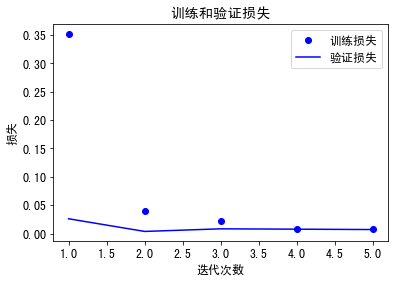

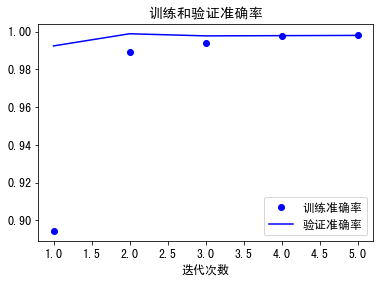

INFO:tensorflow:Assets written to: model_text/assets


INFO:tensorflow:Assets written to: model_text/assets


500/500 [==============================] - 14s 26ms/step - loss: 0.0070 - accuracy: 0.9980


[0.007029801141470671, 0.9980000257492065]

In [4]:
#@title 训练文本模型，用于在colab上面训练model_text,拆分0

!rm /content/model_text -fr
!cp /content/drive/MyDrive/data/tc_wordlist.bin ./
# !cp /content/drive/MyDrive/data/model_0629_1335/model_text ./ -fr
# !cp /content/drive/MyDrive/data/model_text_p96_07142135/ ./model_text/ -fr

# !cp /content/drive/MyDrive/data/model_text_p9920_07171830/ ./model_text -fr

!cp /content/drive/MyDrive/data/tokenizer.bin  ./

random.seed()

pathofflaviatxt = r"./flaviatxt"
leaves_folder = r"Leaves"
imgrootpath = r"./Leaves2"
top_k = 10000
EMBEDDING_DIM = 200  # 词向量维度

pathofflaviatxt = "/content/flaviatxt"
leaves_folder = r"Leaves"
imgrootpath = "/content/Leaves2"

# @title 获取文本featrue
alltxtdata = ""
keyfeature = "叶"

def collectalltxt(pathofflaviatxt):
    alltxtdata = ""
    for x in os.listdir(pathofflaviatxt):
        # print (x)
        alltxtdata += codecs.open(os.path.join(pathofflaviatxt, x), encoding="gbk").read()
    return alltxtdata
alltxtdata = collectalltxt(pathofflaviatxt)

# @title 文本分类
# 这个脚本用来读取腾讯词嵌入中所有的880w的词语，放到一个list中tc_wordlist
if os.path.isfile("tc_wordlist.bin") == False:
    tc_w2v = codecs.open("Tencent_AILab_ChineseEmbedding.txt", encoding="utf-8")
    tc_wordlist = []
    x = tc_w2v.readline()  # skip first line
    x = tc_w2v.readline()
    i = 1
    while x != "":
        tc_wordlist.append(x.split(" ")[0])
        x = tc_w2v.readline()
        if i % 100000 == 0:
            print(i)
        i += 1
    print("have collect tencent word embedding's words to list tc_wordlist")
    print("len(tc_wordlist):", len(tc_wordlist))
    p.dump(tc_wordlist, open("tc_wordlist.bin", "wb"))
tc_wordlist = p.load(open("tc_wordlist.bin", "rb"))

if os.path.isfile("tokenizer.bin") == False:

    # 首先定义一个tokenizer，使用jieba及alltxtdata训练一次，
    # 然后发现有些词语在腾讯词嵌入里面居然没有，那么就重新把那些没有的词从jieba里面删掉。不包含英文
    # 然后再做一次使用jieba及alltxtdata训练，可以得到一个tokenizer里面的词都可以在腾讯词嵌入中找到。
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                      oov_token="<unk>",
                                                      filters='')
    tokenizer.fit_on_texts(jieba.lcut(alltxtdata, HMM=False) + list(re.sub(r'\r|\n', ' ', alltxtdata)))
    print("有多少个不包含的：", len(set(tokenizer.word_index.keys()) - set(tc_wordlist)))
    print("那些不包含的：", (set(tokenizer.word_index.keys()) - set(tc_wordlist)))
    for x in (set(tokenizer.word_index.keys()) - set(tc_wordlist)):
        if re.sub(r"[a-zA-Z]", "", x) != "":
            jieba.del_word(x)
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                      oov_token="<unk>",
                                                      filters='')
    tokenizer.fit_on_texts(jieba.lcut(alltxtdata, HMM=False) + list(re.sub(r'\r|\n', ' ', alltxtdata)))
    tokenizer.word_index['<pad>'] = 0
    tokenizer.index_word[0] = '<pad>'
    # print(len(tokenizer.word_counts))
    tokenizer.word_index['<start>'] = len(tokenizer.word_counts)
    tokenizer.index_word[len(tokenizer.word_counts)] = '<start>'
    tokenizer.word_index['<end>'] = len(tokenizer.word_counts) + 1
    tokenizer.index_word[len(tokenizer.word_counts) + 1] = '<end>'
    p.dump(tokenizer, open("tokenizer.bin", "wb"))
tokenizer = p.load(open("tokenizer.bin", "rb"))

if os.path.isfile("embeddings_matrix.npy") == False:
    # 将所有Tokenizer中用到的那些词的向量添加到embeddings_matrix中。
    # len(tokenizer.word_index.keys())
    # tokenizer.num_words
    vector_size = 200
    embeddings_matrix = np.zeros((tokenizer.num_words+1, vector_size))
    tok_words = tokenizer.word_index.keys()
    # print(tok_words)
    with codecs.open("/content/Tencent_AILab_ChineseEmbedding.txt", encoding="utf-8") as f:
        i = 0
        line_1 = f.readline()
        while line_1 != "":
            tc_word = line_1.split(" ")[0]
            if tc_word in tok_words:
                # print(np.array([float(x) for x in line_1.split(" ")[1:]]))
                embeddings_matrix[tokenizer.word_index[tc_word]] = np.array([float(x) for x in line_1.split(" ")[1:]])
            line_1 = f.readline()
            i += 1
            if i % 100000 == 0:
                print(i)
    print("embeddings_matrix:", embeddings_matrix)

    # 定义Embedding层
    embedding_layer = Embedding(len(embeddings_matrix), EMBEDDING_DIM,
                                weights=[embeddings_matrix],  # 重点：预训练的词向量系数
                                input_length=100,  # 每句话的 最大长度（必须padding）
                                trainable=False  # 是否在 训练的过程中 更新词向量
                                )
    np.save("embeddings_matrix.npy", embeddings_matrix)
embeddings_matrix = np.load("embeddings_matrix.npy")
# 定义Embedding层
embedding_layer = Embedding(len(embeddings_matrix), EMBEDDING_DIM,
                            weights=[embeddings_matrix],  # 重点：预训练的词向量系数
                            input_length=100,  # 每句话的 最大长度（必须padding）
                            trainable=False  # 是否在 训练的过程中 更新词向量
                            )

# model 定义
def create_model():
    if 0:
        model_text = keras.Sequential()
        # embd = keras.layers.Embedding(10000, 200)
        # embd = embedding_layer
        model_text.add(embd)
        gap1d = keras.layers.GlobalAveragePooling1D()
        model_text.add(gap1d)
        # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))
        fc1 = keras.layers.Dense(512, activation='relu')
        model_text.add(fc1)
        fc2 = keras.layers.Dense(256, activation='relu')
        model_text.add(fc2)
        fc3 = keras.layers.Dense(32, activation='softmax')
        model_text.add(fc3)
        model_text.summary()

    model_text = keras.Sequential()
    embd = keras.layers.Embedding(10000+1, 200)
    # embd = embedding_layer
    model_text.add(embd)
    # gap1d = keras.layers.GlobalAveragePooling1D()
    # model_text.add(gap1d)
    model_text.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(400,  return_sequences=True)))
    model_text.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(200)))
    # model_text.add(tf.keras.layers.Bidirectional(tf.keras.layers.GRU(400,  return_sequences=True)))
    # model_text.add(tf.keras.layers.Bidirectional(tf.keras.layers.GRU(200)))
    # model_text.add(tf.keras.layers.GRU(64, return_sequences=True))
    # model_text.add(tf.keras.layers.GRU(32))
    # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))
    fc1 = keras.layers.Dense(512, activation='relu')
    model_text.add(fc1)
    fc3 = keras.layers.Dense(32, activation='softmax')
    model_text.add(fc3)
    model_text.summary()
    model_text.compile(optimizer='adam',
                       loss=tf.keras.losses.categorical_crossentropy,
                       metrics=['accuracy'])
    base_learning_rate = 0.00001
    model_text.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
                       # loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                       loss=tf.keras.losses.categorical_crossentropy,
                       metrics=['accuracy'])
    return model_text
model_text = create_model()

# @title create flavia txt dataset
# vocab_size = 10000
# base_learning_rate = 0.0001
# model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
#   loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
#   metrics=['accuracy'])
def getTokenizerAndKeyword(top_k, alltxtdata, keyfeature):
    #                           filters='!"#$%&*+,:;=?@[\]^_`{|}~ ')
    # tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
    #                                                   oov_token="<unk>",
    #                                                   filters='')
    # # tokenizer.fit_on_texts(alltxtdata)
    # tokenizer.fit_on_texts(jieba.lcut(alltxtdata) + list(alltxtdata))
    # tokenizer.word_index['<pad>'] = 0
    # tokenizer.index_word[0] = '<pad>'
    # # print(len(tokenizer.word_counts))
    # tokenizer.word_index['<start>'] = len(tokenizer.word_counts)
    # tokenizer.index_word[len(tokenizer.word_counts)] = '<start>'
    # tokenizer.word_index['<end>'] = len(tokenizer.word_counts) + 1
    # tokenizer.index_word[len(tokenizer.word_counts) + 1] = '<end>'

    # 从所有的文本feature中，找到包含叶的句子，然后抽取关键词。
    allfiletrue = re.sub(r"\r|\n", r"", alltxtdata)
    allfeature = list(
        x.lstrip().rstrip().replace(" ", "") if keyfeature in x else "" for x in re.split(r"[。;；,]", allfiletrue))
    allfeature = ",".join([x for x in allfeature if x != ""])
    feature_keywords = jieba.analyse.extract_tags(allfeature, 50, allowPOS=("na"))
    feature_keywords_set = set(feature_keywords)
    # print(jieba.lcut(feature))
    print("feature_keywords:", feature_keywords)
    return tokenizer, feature_keywords, feature_keywords_set
tokenizer, feature_keywords, feature_keywords_set = getTokenizerAndKeyword(top_k, alltxtdata, keyfeature)

def gettxtdata_wb(file1):
    global feature_keywords_set
    filetxt = codecs.open(os.path.join(pathofflaviatxt, file1), encoding="gbk").read()
    filetxt = re.sub(r"\r|\n", r"", filetxt)
    feature1 = []
    str1 = []
    feature = list(
        x.lstrip().rstrip().replace(" ", "") if "叶" in x else "" for x in re.split(r"[。;；,：:a-zA-Z]", filetxt))
    for x in feature:
        if x != "":
            # for x1 in x.split("，"):
            if list(feature_keywords_set & set(jieba.lcut(x))) != []:
                str1.extend(x.split("，"))
    return str1

def getrandstr(text1, num1):
    # for _ in range(num1):
    str2 = ""
    rn = np.random.randint(low=0, high=len(text1), size=num1)
    # print (rn)
    for _i in rn:
        tempstr = text1[_i]
        # print("tempstr:",tempstr)
        if str2 != "":
            str2 += ","
        str2 += tempstr
    return str2

wb_d = {}
def create_wbData(liang=3):
    global wb_d
    wb_data = []
    wb_label = []
    wb_d = {}
    for wbf in os.listdir(pathofflaviatxt):
        wb_d[wbf] = gettxtdata_wb(wbf)
    print(wb_d)
    print(wb_d.keys())
    for _ in range(liang):
        for x in wb_d.keys():
            desc_txt = wb_d[x]
            feature1 = []
            feature1.append([y[0] for y in tokenizer.texts_to_sequences(
                [f"<start>"] + jieba.lcut(getrandstr(desc_txt, np.random.randint(10,16)), HMM=False) + [f"<end>"])])
            feature1 = tf.keras.preprocessing.sequence.pad_sequences(feature1, padding='post', maxlen=150)[0]
            wb_data.extend([feature1])

            # wb_data.extend([getrandstr(desc_txt, 8)])
            wb_label.extend([int(x.split(".")[0])])
            # break
    return np.array(wb_data), np.array(wb_label)

BATCH_SIZE = 64
train_d, train_l = create_wbData(1600)
train_l = tf.one_hot(train_l, 32)
test_d, test_l = create_wbData(500)
test_l = tf.one_hot(test_l, 32)

# print(len(d),len(l))
print(train_d.shape, train_l.shape)
print(test_d.shape, test_l.shape)

# train_data = keras.preprocessing.sequence.pad_sequences(d, padding='post', maxlen=256)


# if os.path.isdir("model_text") == True:
if os.path.isdir("model_text") == False:
    def decay(epoch):
        if epoch < 3:
            print("learning rate: 1e-3")
            return 1e-3
        # elif epoch >= 5 and epoch < 10:
        #     print("learning rate: 1e-5")
        #     return 1e-5
        # elif epoch >= 15 and epoch < 20:
        #     print("learning rate: 1e-6")
        #     return 1e-6
        else:
            print("learning rate: 2e-7")
            return 2e-7
    # @title 开始训练
    # 如果学习率太大，特别容易崩，一般来说0.0001就会崩；但是0.00001不会崩。
    # model_text = tf.keras.models.load_model("model_text")
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
    history = model_text.fit(train_d,
                             train_l,
                             epochs=40,
                             batch_size=32,
                             validation_data=(test_d, test_l),
                             callbacks=[tf.keras.callbacks.LearningRateScheduler(decay), early_stop],
                             verbose=1)
    import matplotlib.pyplot as plt
    # history_dict = history
    history_dict = history.history
    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(acc) + 1)

    # “bo”代表 "蓝点"
    plt.plot(epochs, loss, 'bo', label='训练损失')
    # b代表“蓝色实线”
    plt.plot(epochs, val_loss, 'b', label='验证损失')
    plt.title('训练和验证损失')
    plt.xlabel('迭代次数')
    plt.ylabel('损失')
    plt.legend()

    plt.show()

    plt.plot(epochs, acc, 'bo', label='训练准确率')
    # b代表“蓝色实线”
    plt.plot(epochs, val_acc, 'b', label='验证准确率')
    plt.title('训练和验证准确率')
    plt.xlabel('迭代次数')
    plt.ylabel('')
    plt.legend()

    plt.show()
    model_text.save("model_text")

model_text = tf.keras.models.load_model("model_text")
# model_text.predict("123")
# model_text.predict(train_d[:10])[0].shape
model_text.evaluate(test_d, test_l)


In [ ]:
print(test_d[:2])
tokenizer.sequences_to_texts(test_d[0:2])

def create_wbData1(liang=3):
    global wb_d
    wb_data = []
    wb_label = []
    wb_d = {}
    for wbf in os.listdir(pathofflaviatxt):
        wb_d[wbf] = gettxtdata_wb(wbf)
    # print(wb_d)
    # print(wb_d.keys())
    for _ in range(liang):
        for x in wb_d.keys():
            desc_txt = wb_d[x]
            feature1 = []
            a = getrandstr(desc_txt, 8)
            # print(a)
            feature1.append([y[0] for y in tokenizer.texts_to_sequences(
                [f"<start>"] + jieba.lcut(a, HMM=False) + [f"<end>"])])
            feature1 = tf.keras.preprocessing.sequence.pad_sequences(feature1, padding='post', maxlen=150)[0]
            wb_data.extend([feature1])

            # wb_data.extend([getrandstr(desc_txt, 8)])
            wb_label.extend([int(x.split(".")[0])])
            # break
    return np.array(wb_data), np.array(wb_label)


test_d1, test_l1 = create_wbData1(200)
test_l1 = tf.one_hot(test_l1, 32)
model_text.evaluate(test_d1, test_l1)


[[4275   46   40  135 1377   13  324  238  104   13  748  112 1204   67
   707   13   46   40  135 1377   13  226  735   13  177  144   83   56
    18  160   13  204    1   13  270   18 1196  230  395   44    4  448
     7   13   97 1422 1784   13  195   97 1199 4276    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0]
 [4275 1210  162 2019 2020   13 1210  162 2019 2020   13   46  553   13
  3208  395   44  286   44    4  448    7   35    4  448   15   13  229
   268   18    7    9   15   67   13  960   13 3208  395   44  286   44
     4  448

[0.024268990382552147, 0.9940624833106995]

In [ ]:
# train_d, train_l = create_wbData(300)
# train_l = tf.one_hot(train_l, 32)
# test_d, test_l = create_wbData(200)
# test_l = tf.one_hot(test_l, 32)


early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)

def decay(epoch):
    return 2e-7

history = model_text.fit(train_d,
                             train_l,
                             epochs=10,
                             batch_size=32,
                             validation_data=(test_d, test_l),
                             callbacks=[tf.keras.callbacks.LearningRateScheduler(decay), early_stop],
                             verbose=1)
model_text.save("model_text")

Epoch 1/10
3200/3200 [==============================] - 291s 89ms/step - loss: 0.0501 - accuracy: 0.9863 - val_loss: 0.0097 - val_accuracy: 0.9995
Epoch 2/10
3200/3200 [==============================] - 283s 89ms/step - loss: 0.0076 - accuracy: 0.9993 - val_loss: 0.0050 - val_accuracy: 0.9995
Epoch 3/10
3200/3200 [==============================] - 283s 88ms/step - loss: 0.0047 - accuracy: 0.9995 - val_loss: 0.0031 - val_accuracy: 0.9998
Epoch 4/10
3200/3200 [==============================] - 282s 88ms/step - loss: 0.0034 - accuracy: 0.9996 - val_loss: 0.0023 - val_accuracy: 0.9998
Epoch 5/10
3200/3200 [==============================] - 283s 88ms/step - loss: 0.0028 - accuracy: 0.9996 - val_loss: 0.0019 - val_accuracy: 0.9998


INFO:tensorflow:Assets written to: model_text/assets


INFO:tensorflow:Assets written to: model_text/assets


In [ ]:
!rm /content/drive/MyDrive/data/model_text_p9920_07171830 -fr
!cp /content/model_text /content/drive/MyDrive/data/model_text_p9920_07171830 -fr

In [ ]:
# encoding : utf-8 
# @title image 训练的各种头库,拆分1,

# 首先要加载各种使用的库
!pip install thulac
!pip install annoy
!pip install mxnet

import thulac
import tensorflow as tf
# You ll generate plots of attention in order to see which parts of an image
# our model focuses on during captioning
import matplotlib.pyplot as plt
from tqdm import tqdm
# Scikit-learn includes many helpful utilities
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import collections
import random
import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle
import codecs
import gc
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.layers import Conv1D, LSTM, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.models import Sequential
import numpy as np
import tensorflow.keras as keras
import shutil
from tensorflow.keras.preprocessing import image_dataset_from_directory
import jieba
import jieba.analyse
import jieba.posseg as pseg
import json
from collections import OrderedDict
from gensim.models import KeyedVectors
# from annoy import AnnoyIndex
from keras.layers import Embedding
import gensim
from gensim.test.utils import common_texts, get_tmpfile
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.test.utils import datapath
import time
# import mxnet
import os
# print("list mxnet's vector:", mxnet.contrib.text.embedding.get_pretrained_file_names())
# below line can get the pretrained file's url, like
# https://apache-mxnet.s3-accelerate.dualstack.amazonaws.com/gluon/embeddings/fasttext/wiki.ch.zip
# if 0:
#   mxnet.contrib.text.embedding.FastText(pretrained_file_name="wiki.ch.vec")

# @title 复制腾讯词嵌入，wiki.zh.vec。
# 后者应该不用了，因为它没有腾讯词嵌入的东西多。
import os
# if os.path.isfile("Tencent_AILab_ChineseEmbedding.tar.gz") == False:
#   !cp /content/drive/MyDrive/data/Tencent_AILab_ChineseEmbedding.tar.gz ./
#   !tar -zxvf Tencent_AILab_ChineseEmbedding.tar.gz
#
# if os.path.isfile("/content/wiki.zh.vec") == False:
#   !cp /content/drive/MyDrive/data/wiki.zh.vec .

from pylab import mpl
import pickle as p
# from keras.layers import Input, Dense
# from keras.models import Model

loss_plot = []
accu_plot = []

from tensorflow.keras.layers.experimental.preprocessing import RandomFlip
from tensorflow.keras.layers.experimental.preprocessing import RandomRotation



mv: cannot stat '/content/Leaves2/33': No such file or directory
mv: cannot stat '/content/Leaves2/32': No such file or directory


In [ ]:
# @title 获取文本featrue
alltxtdata = ""

def collectalltxt(pathofflaviatxt):
    alltxtdata = ""
    for x in os.listdir(pathofflaviatxt):
        # print (x)
        alltxtdata += codecs.open(os.path.join(pathofflaviatxt, x), encoding="gbk").read()
    return alltxtdata

alltxtdata = collectalltxt(pathofflaviatxt)

# Choose the top 5000 words from the vocabulary
top_k = 10000
tokenizer = ""
keyfeature = "叶"
BUFFER_SIZE = 1000
BATCH_SIZE = 64
targetLen = 150
debugm = 0 # if 0,means only 20% data, if 1 ,means all data .

if os.path.isfile("tokenizer.bin") == True:
    tokenizer = p.load(open("tokenizer.bin", "rb"))

def getTokenizerAndKeyword(top_k, alltxtdata, keyfeature):
    #                           filters='!"#$%&*+,:;=?@[\]^_`{|}~ ')
    # tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
    #                                                   oov_token="<unk>",
    #                                                   filters='')
    # # tokenizer.fit_on_texts(alltxtdata)
    # tokenizer.fit_on_texts(jieba.lcut(alltxtdata) + list(alltxtdata))
    # tokenizer.word_index['<pad>'] = 0
    # tokenizer.index_word[0] = '<pad>'
    # # print(len(tokenizer.word_counts))
    # tokenizer.word_index['<start>'] = len(tokenizer.word_counts)
    # tokenizer.index_word[len(tokenizer.word_counts)] = '<start>'
    # tokenizer.word_index['<end>'] = len(tokenizer.word_counts) + 1
    # tokenizer.index_word[len(tokenizer.word_counts) + 1] = '<end>'

    # 从所有的文本feature中，找到包含叶的句子，然后抽取关键词。
    allfiletrue = re.sub(r"\r|\n", r"", alltxtdata)
    allfeature = list(
        x.lstrip().rstrip().replace(" ", "") if keyfeature in x else "" for x in re.split(r"[。;；,]", allfiletrue))
    allfeature = ",".join([x for x in allfeature if x != ""])
    feature_keywords = jieba.analyse.extract_tags(allfeature, 50, allowPOS=("na"))
    feature_keywords_set = set(feature_keywords)
    # print(jieba.lcut(feature))
    print("feature_keywords:", feature_keywords)
    return tokenizer, feature_keywords, feature_keywords_set
tokenizer, feature_keywords, feature_keywords_set = getTokenizerAndKeyword(top_k, alltxtdata, keyfeature)

# 从文本中抽取包含叶的关键句子，然后向量化。
# 找出文本中包含关键字的那些句子，
def gettxtfeature(file1):
    filetxt = codecs.open(file1, encoding="gbk").read()
    filetxt = re.sub(r"\r|\n", r"", filetxt)
    feature1 = []
    str1 = []
    feature = list(
        x.lstrip().rstrip().replace(" ", "") if keyfeature in x else "" for x in re.split(r"[。;；,：:a-zA-Z]", filetxt))
    for x in feature:
        if x != "":
            for x1 in x.split("，"):
                # if list(feature_keywords_set & set(jieba.lcut(x1))) != []:
                if list(feature_keywords_set & set(jieba.lcut(x1, HMM=False))) != []:
                    str1.append(x1)
    return str1

# for x in os.listdir("/content/flaviatxt"):
#   print(gettxtdatatest(os.path.join("/content/flaviatxt", x))[1])
# gettxtdatatest("/content/flaviatxt/1.txt")

# @title get image feature， 准备img dataset
# InceptionV3
def encodeimgModel():
  # model of get image features
  image_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
  new_input = image_model.input
  hidden_layer = image_model.layers[-1].output
  image_features_extract_model = tf.keras.Model(new_input, hidden_layer)
  return image_features_extract_model

# InceptionV3 guhua
# def encodeimgModel():
#   model_image = tf.keras.models.load_model("model_image")
#   image_model = model_image.layers[:-1]
#   image_model = tf.keras.Model(model_image.input, model_image.layers[-2].output)
#   return image_model

# # 给定图片文件，加载图片转化为 model 使用的格式
def load_image(image_path):
  img = tf.io.read_file(image_path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, (299, 299))
  img = tf.keras.applications.inception_v3.preprocess_input(img)
  return img, image_path

# below code use desnet201 as feature extract, output is (1, 7,7, 1920)
# def encodeimgModel():
#     image_model = tf.keras.applications.DenseNet201(include_top=False, weights='imagenet')
#     new_input = image_model.input
#     hidden_layer = image_model.layers[-1].output
#     image_features_extract_model = tf.keras.Model(new_input, hidden_layer)
#     return image_features_extract_model


# def load_image(image_path):
#     # print(image_path)
#     img = tf.io.read_file(image_path)
#     img = tf.image.decode_jpeg(img, channels=3)
#     img = tf.image.resize(img, (224, 224))
#     # img = tf.keras.applications.DenseNet201..  preprocess_input(img)
#     return img, image_path
image_features_extract_model = encodeimgModel()

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.3),
])
# image_features_extract_model.summary()
# Load the numpy files，获取 image_features_extract_model 过后的 feature，转化为[1, 64, 2048]

def create_wbData(liang=3):
    global wb_d
    wb_data = []
    wb_label = []
    wb_d = {}
    for wbf in os.listdir(pathofflaviatxt):
        wb_d[wbf] = gettxtdata_wb(wbf)
    print(wb_d)
    print(wb_d.keys())
    for _ in range(liang):
        for x in wb_d.keys():
            desc_txt = wb_d[x]
            feature1 = []
            feature1.append([y[0] for y in tokenizer.texts_to_sequences(
                [f"<start>"] + jieba.lcut(getrandstr(desc_txt, 10), HMM=False) + [f"<end>"])])
            feature1 = tf.keras.preprocessing.sequence.pad_sequences(feature1, padding='post', maxlen=150)[0]
            wb_data.extend([feature1])

            # wb_data.extend([getrandstr(desc_txt, 8)])
            wb_label.extend([int(x.split(".")[0])])
            # break
    return np.array(wb_data), np.array(wb_label)
def getrandstr(text1, num1):
    # for _ in range(num1):
    str2 = ""
    rn = np.random.randint(low=0, high=len(text1), size=num1)
    # print (rn)
    for _i in rn:
        tempstr = text1[_i]
        # print("tempstr:",tempstr)
        if str2 != "":
            str2 += ","
        str2 += tempstr
    return str2

def map_func_img_txt(img_name, labclass, filename):
  global wb_d
  feature1 = []
  img_name = img_name.decode()
  labclass = labclass.decode()
#   print (labclass)
  # img_tensor = load_image(os.path.join(labclass, img_name))
  img_tensor = load_image(os.path.join(os.path.join(imgrootpath, labclass), img_name))
#   img_tensor = tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal')(tf.expand_dims(img_tensor[0], 0))
  img_tensor = data_augmentation(tf.expand_dims(img_tensor[0], 0))
#   print(img_tensor[0])
  img_tensor = image_features_extract_model(tf.expand_dims(img_tensor[0], 0))
#   print("img_tensor:", img_tensor.shape)
  img_tensor = tf.reshape(img_tensor, (img_tensor.shape[0], -1, img_tensor.shape[3]))
  img_tensor = tf.squeeze(img_tensor, 0)

#   txtfeature = gettxtfeature(os.path.join(pathofflaviatxt, "%d.txt" % int(labclass)))
  desc_txt = wb_d["%d"%int(labclass) +".txt"]
  str2 = ""
  while len(str2) < targetLen - 5:
      rn = np.random.randint(low=0, high=len(desc_txt), size=1)
      tempstr = desc_txt[rn[0]]
      if str2 != "":
          str2 += ","
      str2 += tempstr
  # print(str2)
  # print (jieba.lcut(str2, HMM=False))
  feature1.append([y[0] for y in tokenizer.texts_to_sequences([f"<start>"] + jieba.lcut(str2, HMM=False)+ [f"<end>"])])
#   feature1.append([y[0] for y in tokenizer.texts_to_sequences([f"<start>"] + jieba.lcut(getrandstr(desc_txt, np.random.randint(10,11)), HMM=False)+ [f"<end>"])])
  feature1 = tf.keras.preprocessing.sequence.pad_sequences(feature1, padding='post', maxlen=targetLen)[0]
  # print(feature1)
  filename = os.path.join(labclass, filename)
  return img_tensor, feature1, filename

# below code is for val_dataset is same for every epoch, if below code is run only once.

def prepareds(imgrootpath, data_times):
  img_to_labelclass = collections.defaultdict(list)
  for root, dirs, files in os.walk(imgrootpath, topdown=False):
      for f in files:
        img_to_labelclass[f].append(root.split("/")[-1])
  # get random filenamelist to shuffle ，同时将做开关将样本数减少以利于调试。
  if debugm == 0:
    img_keys = list(img_to_labelclass.keys())* data_times
  else:
    img_keys = list(img_to_labelclass.keys())
    img_keys = img_keys[:int(len(img_keys) / 5)]
  random.seed(a=123)
  random.shuffle(img_keys)
  print("len(img_keys):", len(img_keys))
  # prepare pair [filename, label]
  slice_index = int(len(img_keys) * 0.8)
  img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]
  img_name_train = []
  cap_train = []
  filname_train = []
  print("start get feature of train data")
  for imgt in tqdm(img_name_train_keys):
      # imgt_d, imgt_l = map_func_img(imgt.encode(), img_to_labelclass[imgt][0].encode())
      imgt_d, imgt_l, imgt_f = map_func_img_txt(imgt.encode(), img_to_labelclass[imgt][0].encode(), imgt)
      img_name_train.extend([imgt_d])
      cap_train.extend([imgt_l])
      filname_train.extend([imgt_f])
  print("start get feature of val data")
  img_name_val = []
  cap_val = []
  filname_val = []
  for imgv in tqdm(img_name_val_keys):
      # imgv_d, imgv_l = map_func_img(imgv.encode(), img_to_labelclass[imgv][0].encode())
      imgv_d, imgv_l, imgv_f = map_func_img_txt(imgv.encode(), img_to_labelclass[imgv][0].encode(), imgv)
      img_name_val.extend([imgv_d])
      cap_val.extend([imgv_l])
      filname_val.extend([imgv_f])

  print("len(img_name_train), len(cap_train), len(img_name_val), len(cap_val):")
  print(len(img_name_train), len(cap_train), len(img_name_val), len(cap_val))
  # here, the cap_train, cap_val are label
  train_dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train, filname_train))
  val_dataset = tf.data.Dataset.from_tensor_slices((img_name_val, cap_val, filname_val))
  print("all image feature have done ")
  print("start change item2 to txt feature")
  # Shuffle and batch
  train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
  train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
  # Shuffle and batch
  val_dataset = val_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
  val_dataset = val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
  return train_dataset, val_dataset

# train_dataset, val_dataset = prepareds(imgrootpath, 1)


feature_keywords: ['无毛', '基部', '柔毛', '先端', '圆形', '楔形', '侧脉', '椭圆形', '叶片', '锯齿', '卵形', '披针', '针形', '小叶', '纸质', '裂片', '花序', '深绿色', '淡绿色', '明显', '圆状', '倒卵形', '边缘', '叶腋', '腺体', '短枝', '卵状', '叶面', '图版', '树皮', '樟脑', '长枝', '锐尖', '革质', '全缘', '小枝', '支脉', '花梗', '花枝', '苞片', '长圆', '大叶', '绿色', '直径', '心形', '灰绿色', '细小', '樟树', '落叶', '樟油']
87916544/87910968 [==============================] - 1s 0us/step


In [ ]:
!rm /content/checkpoints -fr

In [ ]:
# model_text.trainable = True
# @title model 1 define， 拆分3.1
# embedding_dim = 256
# units = 512
top_k = 10000
vocab_size = top_k + 1
embedding_dim = 1024
units = 512


class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

        # hidden shape == (batch_size, hidden_size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        # print("hidden_with_time_axis.shape", hidden_with_time_axis.shape)
        # print("features.shape", features.shape)

        # attention_hidden_layer shape == (batch_size, 64, units)
        attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                             self.W2(hidden_with_time_axis)))
        # print("attention_hidden_layer.shape", attention_hidden_layer.shape)
        # score shape == (batch_size, 64, 1)
        # This gives you an unnormalized score for each image feature.
        score = self.V(attention_hidden_layer)
        # print("score.shape", score.shape)

        # attention_weights shape == (batch_size, 64, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights


class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)
        # self.fc1 = tf.keras.layers.Dense(4096)
        # self.dp = tf.keras.layers.Dropout(0.3)

    def call(self, x):
        # print("x.shape:", x.shape)
        # x = tf.keras.layers.GlobalAveragePooling2D()(x)
        # x = self.fc(x)
        # print("x.shape:", x.shape)
        # x = tf.keras.layers.Dense(2048)(x)
        # x = self.fc1(x)
        # x = self.dp(x)
        x = self.fc(x)
        # print("x.shape:", x.shape)
        x = tf.nn.relu(x)
        # print("x.shape:", x.shape)
        return x


class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.gru1 = tf.keras.layers.GRU(self.units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.units)

    def call(self, x, features, hidden):
        # defining attention as a separate model
        context_vector, attention_weights = self.attention(features, hidden)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the GRU
        output, state = self.gru(x)
        # output, state = self.gru1(output)

        # shape == (batch_size, max_length, hidden_size)
        x = self.fc1(output)

        # x shape == (batch_size * max_length, hidden_size)
        x = tf.reshape(x, (-1, x.shape[2]))

        # output shape == (batch_size * max_length, vocab)
        x = self.fc2(x)

        return x, state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))


def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    # print (mask)
    # print("real:", real.shape, "pred:", pred.shape)
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    # print (loss_)
    loss_ *= mask
    # print(loss_.shape)
    # print("tf.reduce_mean(loss_):", tf.reduce_mean(loss_))
    return tf.reduce_mean(loss_)


def decay(epoch):
  if epoch < 20:
    print("learning rate: 1e-3")
    return 1e-3
  elif epoch >= 20 and epoch < 60:
    print("learning rate: 1e-3")
    return 1e-4
  elif epoch >= 60 and epoch < 90:
    print("learning rate: 1e-3")
    return 1e-5
  else:
    print("learning rate: 1e-3")
    return 1e-6

class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self):
    super(CustomSchedule, self).__init__()

    # self.d_model = d_model
    # self.d_model = tf.cast(self.d_model, tf.float32)

    # self.warmup_steps = warmup_steps

#   def __call__(self, step):
#     arg1 = tf.math.rsqrt(step)
#     arg2 = step * (self.warmup_steps ** -1.5)

#     return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
  
  def __call__(self, step):
    if step < 20:
        print("learning rate: 1e-3")
        return 1e-3
    elif step >= 20 and step < 60:
        print("learning rate: 1e-4")
        return 1e-4
    elif step >= 60 and step < 90:
        print("learning rate: 1e-5")
        return 1e-5
    else:
        print("learning rate: 1e-6")
        return 1e-6

learning_rate1 = CustomSchedule()
# learning_rate_fn = tf.keras.optimizers.schedules.LearningRateSchedule(decay)

boundaries1 = [20, 40, 60, 80]
boundaries1 = list(np.asarray(boundaries1)*23)
values1 = [1e-3, 1e-4, 1e-5, 1e-6, 1e-7]
learning_rate_fn = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries1, values1)

encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00001)
# optimizer = tf.keras.optimizers.Adam()
# optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate_fn)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

# loss_object1 = tf.keras.losses.SparseCategoricalCrossentropy(
#     reduction='none')
loss_object1 = tf.keras.losses.mean_squared_error
loss_object2 = tf.keras.losses.categorical_crossentropy

checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=1)
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    print("start_epoch:", start_epoch)
    # restoring the latest checkpoint in checkpoint_path
    ckpt.restore(ckpt_manager.latest_checkpoint)

# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
# loss_plot = []
# accu_plot = []

# base_model_DenseNet201 = tf.keras.applications.DenseNet201(input_shape=(224,224,3),
#   include_top=False,
#   weights='imagenet'
#   )
# base_model = base_model_DenseNet201
# base_model.trainable = False

# global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
# prediction_layer = tf.keras.layers.Dense(32)
# model_image = Sequential()
# # model.add(rescale)
# # model.add(base_model)
# model_image.add(Flatten())
# # model_image.add(global_average_layer)
# model_image.add(tf.keras.layers.Dense(1024))
# model_image.add(tf.keras.layers.Dense(256))
# model_image.add(prediction_layer)


@tf.function
def train_step(img_tensor, target, fname):
  global predictions_txtlist
#   print(img_tensor.shape)
  loss = 0
  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])
  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
  predictions_txtlist = dec_input
  predictions_txtlist = tf.cast(predictions_txtlist, dtype=tf.int64)
  # predictions_txtlist = tf.squeeze(predictions_txtlist, 1)
#   img_tensor = tf.reshape(img_tensor, [64, 8,8,2048])
  with tf.GradientTape() as tape:
    features = encoder(img_tensor)

    for i in range(1, target.shape[1]):
      # passing the features through the decoder
    #   print (dec_input)
      predictions, hidden, _ = decoder(dec_input, features, hidden)
    #   print("predictions:", predictions)
      predicted_id = tf.random.categorical(predictions, 1)
      # predicted_id = tf.case(predicted_id, dtype=tf.int64)
    #   print("predicted_id:", predicted_id)

      # print (tf.equal(predictions_txtlist , 0))
      # if tf.equal(predictions_txtlist , 0):
      #     predictions_txtlist = tf.squeeze(predicted_id)
      # else:
      #     print ("predictions_txtlist:", predictions_txtlist)
      #     print ("tf.squeeze(predicted_id):", tf.squeeze(predicted_id))
      # temp1 = tf.squeeze(predicted_id)
      # print (temp1)
    #   print ("before predictions_txtlist:", predictions_txtlist)
      predictions_txtlist = tf.concat([predictions_txtlist, predicted_id], axis = 1)
      
      # predictions_txtlist = tf.squeeze(predictions_txtlist, -1)
      # predictions_txtlist = tf.reshape(predictions_txtlist, [predictions_txtlist[0], predictions_txtlist[-1]])
    #   print ("predictions_txtlist:", predictions_txtlist)
          # predictions_txtlist = tf.concat((predictions_txtlist, predicted_id), axis=1)
          # tf.stack((a, b), axis=2)
          # tf.stack((a, b), axis=1)
      # predicted_id = predicted_id[0][0]
      # print(predicted_id)
      # predicted_id = predicted_id.numpy()
      # print(predicted_id)
      # predictions_txtlist.append(tokenizer.index_word.get(predicted_id, " "))
      # predictions_list.append(predictions)
      loss += loss_function(target[:, i], predictions)
      # print (loss)
      # using teacher forcing
      dec_input = tf.expand_dims(target[:, i], 1)
    #   print ("\n")
    if 0:
        # tf.reduce_mean(loss_object(fname1, predictresult))
        # print("predictions_txtlist:",predictions_txtlist)
        # fname1= [int(x.numpy().split(b"/")[0]) for x in fname]
        # print("fname1:",fname)
        # p.dump(predictions_txtlist, open("predictions_txtlist.bin", "wb"))
        predictresult = tf.math.softmax(model_text(predictions_txtlist))
        # print ("predictresult 1:", predictresult)
        # print("fname:", fname)
        # print("tf.argmax(predictresult):", tf.argmax(predictresult, axis=-1))
        l = loss_object1(fname, tf.argmax(predictresult, axis=-1))
        # l[tf.is_nan(l)]=0
        # l = tf.clip_by_value(l, -10, 10)
        # p.dump(fname, open("fname.bin", "wb"))
        # p.dump(predictresult, open("predictresult.bin", "wb"))
        # loss1 = tf.reduce_mean(l)
        loss1 = l
        loss1 = tf.cast(loss1, dtype=loss.dtype) * 0.1

        m = loss_object2(tf.cast(tf.one_hot(tf.cast(fname, dtype=tf.int32), 32), dtype=tf.float32), tf.cast(predictresult, dtype=tf.float32))
        loss2 = tf.reduce_mean(m)
        # print ("loss2:", loss2)
        # print ("loss1:", loss1)
        # print ("lossl:", l)
        if 0:
            loss += loss1
        if 1:
            loss += loss2.numpy()
        # print ("loss 2:", loss)
    # l = loss_object1(fname, tf.argmax(predictresult, axis=-1))
    # loss1 = l
    # loss1 = tf.cast(loss1, dtype=loss.dtype) * 0.1

    # predictresult = tf.math.softmax(model_image(img_tensor))
    # m = loss_object2(tf.cast(tf.one_hot(tf.cast(fname, dtype=tf.int32), 32), dtype=tf.float32), tf.cast(predictresult, dtype=tf.float32))
    # loss2 = tf.reduce_mean(m)
    # loss += loss2.numpy()

  # print("loss:", loss.shape)
  # print("loss:", loss.shape)
  # print("loss1:", loss_object(fname1, predictresult))
  # for x,y in zip(iter(fname), iter(predictresult)):
    # print (x,y)
  # raise("456")
  total_loss = (loss / int(target.shape[1]))
#   total_loss/=0.1
#   tf.print("loss:", loss)
#   loss=loss*0.1
#   tf.print("loss:", loss)
  trainable_variables = encoder.trainable_variables + decoder.trainable_variables # + model_image.trainable_variables
  gradients = tape.gradient(loss, trainable_variables)
  optimizer.apply_gradients(zip(gradients, trainable_variables))
  return loss, total_loss
# train_step(img_tensor, target, flist)
# fname1= [int(x.numpy().split(b"/")[0]) for x in fname]



start_epoch: 21


In [ ]:
#@title evaluate 函数
max_length = 100
attention_features_shape = 64 # 64 for inceptionV3, 49 for desnet201

# checkpoint_path = "./checkpoints/train"
# ckpt = tf.train.Checkpoint(encoder=encoder,
#                            decoder=decoder,
#                            optimizer=optimizer)
# ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=1)
# start_epoch = 0
# if ckpt_manager.latest_checkpoint:
#     start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
#     print("start_epoch:", start_epoch)
#     # restoring the latest checkpoint in checkpoint_path
#     ckpt.restore(ckpt_manager.latest_checkpoint)

@tf.function
def evaluate(images_tensor, target, fname):
    attention_plot = np.zeros((max_length, attention_features_shape))
    # print("image.shape", image.shape)

    # hidden = decoder.reset_state(batch_size=1)
    hidden = decoder.reset_state(batch_size=target.shape[0])

    # temp_input = tf.expand_dims(load_image(image)[0], 0)
    # temp_input = tf.expand_dims(image, 0)
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    dec_end = tf.expand_dims([tokenizer.word_index['<end>']] * target.shape[0], 1)
    dec_end = tf.cast(dec_end, dtype=tf.int64)
    dec_zeros = tf.zeros((target.shape[0], 150 - 110 + 2),dtype=tf.int64) # 2 means length of start and end 


    # img_tensor_val = image_features_extract_model(temp_input)
    # img_tensor_val = temp_input
    # img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    # print("images_tensor.shape", images_tensor.shape)
    # images_tensor = tf.reshape(images_tensor, [64, 8,8,2048])
    features = encoder(images_tensor)
    # print("features.shape:", features.shape)

    # dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    # print ("hidden:",hidden.shape)
    # print ("dec_input:",dec_input.shape)
    # print ("features:",features.shape)
    # raise ("123")
    
    result = []
    # predictions_txtlist = []

    predictions_txtlist = dec_input
    predictions_txtlist = tf.cast(predictions_txtlist, dtype=tf.int64)

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
        # print(attention_weights.shape)

        # attention_plot[i] = tf.reshape(attention_weights, (-1,)).numpy()

        # predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        # result.append(tokenizer.index_word.get(predicted_id, " "))

        predicted_id = tf.random.categorical(predictions, 1)
        predictions_txtlist = tf.concat([predictions_txtlist, predicted_id], axis = 1)


        # if tokenizer.index_word[predicted_id] == '<end>':
        #     return result, attention_plot

        # if tokenizer.index_word.get(predicted_id, " ") == '<end>':
        #     return result, attention_plot

        # dec_input = tf.expand_dims([predicted_id], 0)
        dec_input = predicted_id
    predictions_txtlist = tf.concat([predictions_txtlist, dec_end], axis = 1)
    predictions_txtlist = tf.concat([predictions_txtlist, dec_zeros], axis = 1)
    
    # attention_plot = attention_plot[:len(result), :]
    return predictions_txtlist, attention_plot

# @tf.function
def testonvalimage():
    fname1_list = []
    result_list = []
    # for imgs, ls, fl in tqdm(val_dataset,ncols=80):
    # for imgs, ls, fl in val_dataset:
    for (batch, (imgs, ls, fl)) in enumerate(val_dataset):
    # for (batch, (imgs, ls, fl)) in enumerate(train_dataset):
    # for (batch, (imgs, ls, fl)) in enumerate(train_dataset1):
        # print (imgs, ls, fl)
        # raise ("123")
        if len(imgs) != 64:
            break
        
        # for x in fl:
        #     print(tf.strings.split(x,b"/"))
            # int(x.numpy().split(b"/")[0]
        # fname1= [int(x.split(b"/")[0]) for x in fl]
        fname1= [int(tf.strings.split(x,b"/")[0]) for x in fl]
        # fname1 = np.array(fname1, dtype=np.float32)
        fname1 = tf.convert_to_tensor(fname1, dtype=tf.float32)
        # print ("fname1:", fname1)

        # batch_loss, t_loss = train_step(img_tensor, target, fname1)
        # print(imgs, ls, fl)
        # print(imgs.shape)
        # print(ls.shape)

        # rid = np.random.randint(0, len(imgs))
        # print(rid)
        # image = imgs[rid]
        # print(imgs[rid])
        # print(ls[rid])
        # print(fl[rid])
        # print("image.shape", image.shape)
        # print(image,ls[rid])
        # real_caption = ' '.join([tokenizer.index_word[i] for i in np.array(ls[rid]) if i not in [0]])
        # print(real_caption)
        result = []
        # for _ in range(10):
        #   result1, attention_plot = evaluate(image)
        #   result.extend(result1[:-1])
        # while len(result) <50:
        result, attention_plot = evaluate(imgs, ls, fname1)
        # print(len(result[0]))
        # print(fl[rid])
        # print(fl[rid].decode())
        # real_caption = codecs.open("./flaviatxt/" + "%0d" % int(fl[rid].numpy().decode().split("/")[0]) + ".txt", encoding="gbk").read()
        # print('Real Caption:', real_caption)
        # print(result)
        # tokenizer.text
        # print (tokenizer.text  result)
        # print("result:",result)
        # print("tf.one_hot(fname1, 32):", tf.one_hot(tf.cast(fname1,dtype=tf.int32), 32))
        # if fname1_list == []:
        #     fname1_list = fname1
        # else:
        #     fname1_list = tf.concat([fname1_list, fname1], axis = 1)
        fname1_list.append(fname1)
        result_list.append(result)
        # if result_list == []:
        #     result_list = result
        # else:
        #     result_list = tf.concat([result_list, result], axis = 1)
        
        # print(tokenizer.texts_to_sequences([result]))
        # result_seq = tokenizer.texts_to_sequences([result])


        # np.argmax(model_text.predict(result_seq))
        # print(np.argmax(model_text.predict(result_seq)))

        # print('Prediction Caption:', ''.join(result))
        # result, attention_plot = evaluate(image)
        # PIL.open
        # print(fl[rid])
        # print(fl[rid].decode())
        # plt.title("实际图片")
        # print(result)
        # print(result[0])
        # print(tokenizer.index_word.get(result[0], " "))
        # print(tokenizer.sequences_to_texts(result.numpy()))
        # result.append(tokenizer.index_word.get(result, " "))

        # plt.imshow(Image.open(os.path.join(imgrootpath, fl[rid].numpy().decode())))
        # testimagepath = os.path.join(imgrootpath, fl[rid].numpy().decode())
        # plot_attention(testimagepath, result, attention_plot)
    fname1_list = tf.convert_to_tensor(fname1_list, dtype=tf.int32)
    result_list = tf.convert_to_tensor(result_list, dtype=tf.int32)

    # print("fname1_list:", fname1_list)
    # print("result_list:", result_list)
    # print ((1,) + tuple(result_list.shape[-1:]))
    # print (result_list[1:])
    fname1_list = tf.reshape(fname1_list, (-1,))
    # fname1_list = tf.reshape(fname1_list, tuple(fname1_list.shape[-1]))
    result_list = tf.reshape(result_list, ((-1,) + tuple(result_list.shape[-1:])))
    # result_list = tf.reshape(tf.convert_to_tensor(result_list), 0)
    # print("fname1_list:", fname1_list)
    # print("result_list:", result_list)
    
    fname1_onehot = tf.one_hot(tf.cast(fname1_list,dtype=tf.int32), 32)
    evaresult = model_text.evaluate(tf.cast(result_list, dtype=tf.int32), fname1_onehot)
    return evaresult
    # print(classification_report(tf.argmax(tf.convert_to_tensor(model_text.predict(tf.cast(result_list, dtype=tf.int32))),axis=1), fname1_list))
    # fname1_list = list(fname1_list.numpy())
    # print("fname1_list:", fname1_list)
    # for x in range(1,34):
    #     print(x, fname1_list.count(x))

def testontrainimage():
    fname1_list = []
    result_list = []
    # for imgs, ls, fl in tqdm(val_dataset,ncols=80):
    # for imgs, ls, fl in val_dataset:
    for (batch, (imgs, ls, fl)) in enumerate(train_dataset):
    # for (batch, (imgs, ls, fl)) in enumerate(train_dataset):
    # for (batch, (imgs, ls, fl)) in enumerate(train_dataset1):
        # print (imgs, ls, fl)
        # raise ("123")
        if len(imgs) != 64:
            break
        
        # for x in fl:
        #     print(tf.strings.split(x,b"/"))
            # int(x.numpy().split(b"/")[0]
        # fname1= [int(x.split(b"/")[0]) for x in fl]
        fname1= [int(tf.strings.split(x,b"/")[0]) for x in fl]
        # fname1 = np.array(fname1, dtype=np.float32)
        fname1 = tf.convert_to_tensor(fname1, dtype=tf.float32)
        # print ("fname1:", fname1)

        # batch_loss, t_loss = train_step(img_tensor, target, fname1)
        # print(imgs, ls, fl)
        # print(imgs.shape)
        # print(ls.shape)

        # rid = np.random.randint(0, len(imgs))
        # print(rid)
        # image = imgs[rid]
        # print(imgs[rid])
        # print(ls[rid])
        # print(fl[rid])
        # print("image.shape", image.shape)
        # print(image,ls[rid])
        # real_caption = ' '.join([tokenizer.index_word[i] for i in np.array(ls[rid]) if i not in [0]])
        # print(real_caption)
        result = []
        # for _ in range(10):
        #   result1, attention_plot = evaluate(image)
        #   result.extend(result1[:-1])
        # while len(result) <50:
        result, attention_plot = evaluate(imgs, ls, fname1)
        # print(len(result[0]))
        # print(fl[rid])
        # print(fl[rid].decode())
        # real_caption = codecs.open("./flaviatxt/" + "%0d" % int(fl[rid].numpy().decode().split("/")[0]) + ".txt", encoding="gbk").read()
        # print('Real Caption:', real_caption)
        # print(result)
        # tokenizer.text
        # print (tokenizer.text  result)
        # print("result:",result)
        # print("tf.one_hot(fname1, 32):", tf.one_hot(tf.cast(fname1,dtype=tf.int32), 32))
        # if fname1_list == []:
        #     fname1_list = fname1
        # else:
        #     fname1_list = tf.concat([fname1_list, fname1], axis = 1)
        fname1_list.append(fname1)
        result_list.append(result)
        # if result_list == []:
        #     result_list = result
        # else:
        #     result_list = tf.concat([result_list, result], axis = 1)
        
        # print(tokenizer.texts_to_sequences([result]))
        # result_seq = tokenizer.texts_to_sequences([result])


        # np.argmax(model_text.predict(result_seq))
        # print(np.argmax(model_text.predict(result_seq)))

        # print('Prediction Caption:', ''.join(result))
        # result, attention_plot = evaluate(image)
        # PIL.open
        # print(fl[rid])
        # print(fl[rid].decode())
        # plt.title("实际图片")
        # print(result)
        # print(result[0])
        # print(tokenizer.index_word.get(result[0], " "))
        # print(tokenizer.sequences_to_texts(result.numpy()))
        # result.append(tokenizer.index_word.get(result, " "))

        # plt.imshow(Image.open(os.path.join(imgrootpath, fl[rid].numpy().decode())))
        # testimagepath = os.path.join(imgrootpath, fl[rid].numpy().decode())
        # plot_attention(testimagepath, result, attention_plot)
    fname1_list = tf.convert_to_tensor(fname1_list, dtype=tf.int32)
    result_list = tf.convert_to_tensor(result_list, dtype=tf.int32)

    # print("fname1_list:", fname1_list)
    # print("result_list:", result_list)
    # print ((1,) + tuple(result_list.shape[-1:]))
    # print (result_list[1:])
    fname1_list = tf.reshape(fname1_list, (-1,))
    # fname1_list = tf.reshape(fname1_list, tuple(fname1_list.shape[-1]))
    result_list = tf.reshape(result_list, ((-1,) + tuple(result_list.shape[-1:])))
    # result_list = tf.reshape(tf.convert_to_tensor(result_list), 0)
    # print("fname1_list:", fname1_list)
    # print("result_list:", result_list)
    
    fname1_onehot = tf.one_hot(tf.cast(fname1_list,dtype=tf.int32), 32)
    evaresult = model_text.evaluate(tf.cast(result_list, dtype=tf.int32), fname1_onehot)
    return evaresult
    # print(classification_report(tf.argmax(tf.convert_to_tensor(model_text.predict(tf.cast(result_list, dtype=tf.int32))),axis=1), fname1_list))
    # fname1_list = list(fname1_list.numpy())
    # print("fname1_list:", fname1_list)
    # for x in range(1,34):
    #     print(x, fname1_list.count(x))
# testontrainimage()
# testonvalimage()
# testonvalimage()
# testonvalimage()
# testonvalimage()

In [ ]:
max_length = 50
print("testonvalimage50:", testonvalimage(),testonvalimage(),testonvalimage())
max_length = 60
print("testonvalimage60:", testonvalimage(),testonvalimage(),testonvalimage())
max_length = 70
print("testonvalimage70:", testonvalimage(),testonvalimage(),testonvalimage())
max_length = 80
print("testonvalimage80:", testonvalimage(),testonvalimage(),testonvalimage())
max_length = 90
print("testonvalimage90:", testonvalimage(),testonvalimage(),testonvalimage())
max_length = 100
print("testonvalimage100:", testonvalimage(),testonvalimage(),testonvalimage())
max_length = 110
print("testonvalimage110:", testonvalimage(),testonvalimage(),testonvalimage())
max_length = 120
print("testonvalimage120:", testonvalimage(),testonvalimage(),testonvalimage())
max_length = 130
print("testonvalimage130:", testonvalimage(),testonvalimage(),testonvalimage())
max_length = 140
print("testonvalimage140:", testonvalimage(),testonvalimage(),testonvalimage())
# max_length = 150
# print("testonvalimage150:", testonvalimage(),testonvalimage(),testonvalimage())

12/12 [==============================] - 0s 18ms/step - loss: 3.5975 - accuracy: 0.4375
testonvalimage50: [3.7736175060272217, 0.4296875] [3.784722089767456, 0.4192708432674408] [3.597476005554199, 0.4375]
12/12 [==============================] - 0s 19ms/step - loss: 2.9788 - accuracy: 0.5078
testonvalimage60: [2.922229051589966, 0.5182291865348816] [3.0437793731689453, 0.5234375] [2.978846311569214, 0.5078125]
12/12 [==============================] - 0s 22ms/step - loss: 2.2291 - accuracy: 0.6276
testonvalimage70: [2.2861592769622803, 0.6328125] [2.3729896545410156, 0.59375] [2.229055643081665, 0.6276041865348816]
12/12 [==============================] - 0s 23ms/step - loss: 1.4053 - accuracy: 0.7135
testonvalimage80: [1.5356531143188477, 0.71875] [1.497470498085022, 0.7317708134651184] [1.405260682106018, 0.7135416865348816]
12/12 [==============================] - 0s 25ms/step - loss: 0.9324 - accuracy: 0.8229
testonvalimage90: [1.126487135887146, 0.8072916865348816] [0.811311244964

In [ ]:
max_length = 80
print("testonvalimage80:", testonvalimage(),testonvalimage(),testonvalimage())
max_length = 83
print("testonvalimage83:", testonvalimage(),testonvalimage(),testonvalimage())
max_length = 86
print("testonvalimage86:", testonvalimage(),testonvalimage(),testonvalimage())
max_length = 89
print("testonvalimage89:", testonvalimage(),testonvalimage(),testonvalimage())
max_length = 92
print("testonvalimage92:", testonvalimage(),testonvalimage(),testonvalimage())
max_length = 95
print("testonvalimage95:", testonvalimage(),testonvalimage(),testonvalimage())
max_length = 98
print("testonvalimage98:", testonvalimage(),testonvalimage(),testonvalimage())
max_length = 101
print("testonvalimage101:", testonvalimage(),testonvalimage(),testonvalimage())
max_length = 104
print("testonvalimage104:", testonvalimage(),testonvalimage(),testonvalimage())
max_length = 107
print("testonvalimage107:", testonvalimage(),testonvalimage(),testonvalimage())
max_length = 110
print("testonvalimage110:", testonvalimage(),testonvalimage(),testonvalimage())


48/48 [==============================] - 1s 26ms/step - loss: 0.1756 - accuracy: 0.9714
testonvalimage80: [0.1655111163854599, 0.9700520634651184] [0.21008090674877167, 0.9635416865348816] [0.1756054311990738, 0.9713541865348816]
48/48 [==============================] - 1s 26ms/step - loss: 0.1909 - accuracy: 0.9740
testonvalimage83: [0.18088819086551666, 0.9733073115348816] [0.17570118606090546, 0.9720051884651184] [0.1908537894487381, 0.9739583134651184]
48/48 [==============================] - 1s 26ms/step - loss: 0.2422 - accuracy: 0.9596
testonvalimage86: [0.19918513298034668, 0.9622395634651184] [0.2050970196723938, 0.9641926884651184] [0.24218523502349854, 0.9596354365348816]
48/48 [==============================] - 1s 26ms/step - loss: 0.1909 - accuracy: 0.9655
testonvalimage89: [0.21644961833953857, 0.9609375] [0.20298552513122559, 0.9641926884651184] [0.19094650447368622, 0.9654948115348816]
48/48 [==============================] - 1s 26ms/step - loss: 0.1814 - accuracy: 0.97

In [ ]:
max_length = 100
print("testonvalimage100:", testonvalimage(),testonvalimage(),testonvalimage())

48/48 [==============================] - 1s 25ms/step - loss: 0.2065 - accuracy: 0.9681
testonvalimage100: [0.21163101494312286, 0.9654948115348816] [0.20630019903182983, 0.9674479365348816] [0.2065468579530716, 0.9680989384651184]


In [ ]:
!cp /content/checkpoints /content/checkpoints1 -fr


In [ ]:
!rm /content/checkpoints -fr

In [ ]:
!cp /content/drive/MyDrive/data/model_inceptionV3_07131727/checkpoints ./checkpoints -fr

In [ ]:
train_dataset, val_dataset = prepareds(imgrootpath, 3)

  0%|          | 1/4608 [00:00<11:00,  6.97it/s]

len(img_keys): 5760
start get feature of train data


  0%|          | 1/1152 [00:00<02:16,  8.45it/s]

start get feature of val data


100%|██████████| 1152/1152 [02:22<00:00,  8.09it/s]


len(img_name_train), len(cap_train), len(img_name_val), len(cap_val):
4608 4608 1152 1152
all image feature have done 
start change item2 to txt feature


Epoch 1 Batch 0 Loss 0.3269
total_loss, num_steps: tf.Tensor(16.136362, shape=(), dtype=float32) 1
Epoch 1 Loss 16.136362
Time taken for 1 epoch 205.76828002929688 sec

96/96 [==============================] - 2s 24ms/step - loss: 0.0453 - accuracy: 0.9899
train accuracy: 0.9899088740348816
24/24 [==============================] - 1s 24ms/step - loss: 0.1382 - accuracy: 0.9779
validation accuracy: 0.9791666865348816
Epoch 2 Batch 0 Loss 0.3450
total_loss, num_steps: tf.Tensor(15.799903, shape=(), dtype=float32) 1
Epoch 2 Loss 15.799903
Time taken for 1 epoch 29.13638734817505 sec

96/96 [==============================] - 2s 24ms/step - loss: 0.0508 - accuracy: 0.9902
train accuracy: 0.990234375
24/24 [==============================] - 1s 24ms/step - loss: 0.1781 - accuracy: 0.9753
validation accuracy: 0.9817708134651184
Epoch 3 Batch 0 Loss 0.3302
total_loss, num_steps: tf.Tensor(15.622701, shape=(), dtype=float32) 1
Epoch 3 Loss 15.622701
Time taken for 1 epoch 29.037232398986816 sec


  0%|          | 1/3072 [00:00<06:14,  8.20it/s]

len(img_keys): 3840
start get feature of train data


  0%|          | 1/768 [00:00<01:28,  8.62it/s]

start get feature of val data


100%|██████████| 768/768 [01:29<00:00,  8.55it/s]


len(img_name_train), len(cap_train), len(img_name_val), len(cap_val):
3072 3072 768 768
all image feature have done 
start change item2 to txt feature
Epoch 31 Loss 9.798469
Time taken for 1 epoch 474.23294401168823 sec

96/96 [==============================] - 2s 24ms/step - loss: 0.3082 - accuracy: 0.9421
train accuracy: 0.9420573115348816
24/24 [==============================] - 1s 25ms/step - loss: 0.2587 - accuracy: 0.9570
validation accuracy: 0.95703125
Epoch 32 Batch 0 Loss 0.5949
total_loss, num_steps: tf.Tensor(26.694683, shape=(), dtype=float32) 1
Epoch 32 Loss 26.694683
Time taken for 1 epoch 29.780550479888916 sec

96/96 [==============================] - 2s 25ms/step - loss: 0.2118 - accuracy: 0.9541
train accuracy: 0.9541015625
24/24 [==============================] - 1s 25ms/step - loss: 0.2767 - accuracy: 0.9414
validation accuracy: 0.953125
Epoch 33 Batch 0 Loss 0.4739
total_loss, num_steps: tf.Tensor(20.87203, shape=(), dtype=float32) 1
Epoch 33 Loss 20.872030
Time ta

  0%|          | 1/3072 [00:00<05:50,  8.76it/s]

len(img_keys): 3840
start get feature of train data


  0%|          | 1/768 [00:00<01:34,  8.10it/s]

start get feature of val data


100%|██████████| 768/768 [01:29<00:00,  8.58it/s]


len(img_name_train), len(cap_train), len(img_name_val), len(cap_val):
3072 3072 768 768
all image feature have done 
start change item2 to txt feature
Epoch 61 Loss 11.314287
Time taken for 1 epoch 478.92995595932007 sec

96/96 [==============================] - 2s 25ms/step - loss: 0.1882 - accuracy: 0.9606
train accuracy: 0.9606119990348816
24/24 [==============================] - 1s 25ms/step - loss: 0.3938 - accuracy: 0.9492
validation accuracy: 0.9609375
Epoch 62 Batch 0 Loss 0.5563
total_loss, num_steps: tf.Tensor(25.374527, shape=(), dtype=float32) 1
Epoch 62 Loss 25.374527
Time taken for 1 epoch 29.13921284675598 sec

96/96 [==============================] - 2s 25ms/step - loss: 0.2490 - accuracy: 0.9538
train accuracy: 0.9537760615348816
24/24 [==============================] - 1s 25ms/step - loss: 0.3887 - accuracy: 0.9401
validation accuracy: 0.9453125
Epoch 63 Batch 0 Loss 0.4519
total_loss, num_steps: tf.Tensor(20.958492, shape=(), dtype=float32) 1
Epoch 63 Loss 20.958492


  0%|          | 1/3072 [00:00<06:36,  7.75it/s]

len(img_keys): 3840
start get feature of train data


  0%|          | 1/768 [00:00<01:30,  8.46it/s]

start get feature of val data


100%|██████████| 768/768 [01:28<00:00,  8.68it/s]


len(img_name_train), len(cap_train), len(img_name_val), len(cap_val):
3072 3072 768 768
all image feature have done 
start change item2 to txt feature
Epoch 91 Loss 11.001510
Time taken for 1 epoch 474.44784593582153 sec

96/96 [==============================] - 2s 25ms/step - loss: 0.2300 - accuracy: 0.9642
train accuracy: 0.9641926884651184
24/24 [==============================] - 1s 25ms/step - loss: 0.2323 - accuracy: 0.9596
validation accuracy: 0.9609375
Epoch 92 Batch 0 Loss 0.5729
total_loss, num_steps: tf.Tensor(25.328918, shape=(), dtype=float32) 1
Epoch 92 Loss 25.328918
Time taken for 1 epoch 29.625033617019653 sec

96/96 [==============================] - 2s 24ms/step - loss: 0.2322 - accuracy: 0.9616
train accuracy: 0.9615885615348816
24/24 [==============================] - 1s 25ms/step - loss: 0.3925 - accuracy: 0.9453
validation accuracy: 0.9609375
Epoch 93 Batch 0 Loss 0.4686
total_loss, num_steps: tf.Tensor(21.14229, shape=(), dtype=float32) 1
Epoch 93 Loss 21.142290


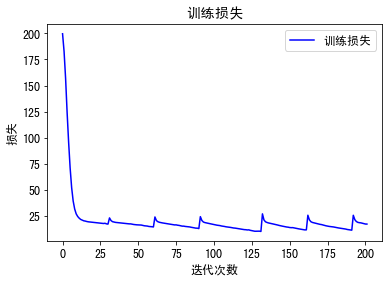

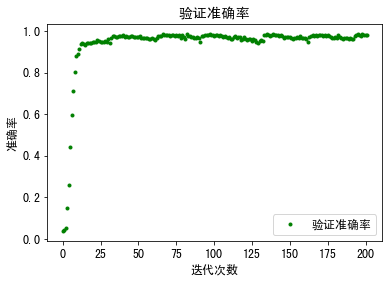

In [ ]:
# import os
# os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]="true"
# import tensorflow as tf
# gpus = tf.config.list_physical_devices('GPU')
# gpu = gpus[0]

# tf.config.experimental.set_memory_growth(gpu, True)

# @title train 拆分3.2
                                                        
# if os.path.isdir("model_image") == False:
#     model_image = tf.keras.models.load_model("model_image")

# def loss_function(real, pred):
#     mask = tf.math.logical_not(tf.math.equal(real, 0))
#     # print (mask)
#     print("real:", real, "pred:", pred)
#     loss_ = loss_object(real, pred)
#     mask = tf.cast(mask, dtype=loss_.dtype)
#     # print (loss_)
#     loss_ *= mask
#     # print(loss_.shape)
#     return tf.reduce_mean(loss_)*0.01

# optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00001)

def start_train():
    global train_dataset, val_dataset
    # gc.collect()

    EPOCHS = 100
    # train_dataset, val_dataset = prepareds(imgrootpath, 2)

    # num_steps = len(train_dataset) // BATCH_SIZE
    num_steps = 1
    start_epoch = 0
    # if ckpt_manager.latest_checkpoint:
    #   start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    #   # restoring the latest checkpoint in checkpoint_path
    #   ckpt.restore(ckpt_manager.latest_checkpoint)

    for epoch in range(start_epoch, EPOCHS+1):
        start = time.time()
        total_loss = 0
        for (batch, (img_tensor, target, flist)) in enumerate(train_dataset):
            # print(batch, (img_tensor, target, flist))
            # print(batch)
            fname1= [int(x.numpy().split(b"/")[0]) for x in flist]
            # fname1 = np.array(fname1, dtype=np.float32)
            fname1 = tf.convert_to_tensor(fname1, dtype=tf.float32)
            batch_loss, t_loss = train_step(img_tensor, target, fname1)
            # raise ("123")
            total_loss += t_loss
            if batch % 100 == 0:
                print('Epoch {} Batch {} Loss {:.4f}'.format(
                    epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
        # storing the epoch end loss value to plot later
        print("total_loss, num_steps:", total_loss, num_steps)
        loss_plot.append(total_loss / num_steps)
        if epoch % 5 == 0:
            ckpt_manager.save()
            # model_text.save("model_text")
            if epoch != 0 and epoch % 30 == 0:
                train_dataset, val_dataset = prepareds(imgrootpath, 2)
        print('Epoch {} Loss {:.6f}'.format(epoch + 1, total_loss / num_steps))
        print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
        # print("testonvalimage:", testonvalimage(),testonvalimage(),testonvalimage(),testonvalimage(),testonvalimage(),testonvalimage())
        ra = testontrainimage()[1]
        # rb = testontrainimage()[1]
        # rc = testontrainimage()[1]
        # rd = max(ra,rb,rc)
        print("train accuracy:", ra)
        ra = testonvalimage()[1]
        rb = testonvalimage()[1]
        rc = testonvalimage()[1]
        rd = max(ra,rb,rc)
        accu_plot.append(rd)
        print("validation accuracy:", rd)

    # epochs = range(1, len(acc) + 1)

    # “bo”代表 "蓝点"
    plt.plot(loss_plot, 'b', label='训练损失')
    # plt.plot(accu_plot, 'b', label='验证准确率')
    # b代表“蓝色实线”
    # plt.plot(epochs, val_loss, 'b', label='验证损失')
    plt.title('训练损失')
    plt.xlabel('迭代次数')
    plt.ylabel('损失')
    plt.legend()
    plt.show()

    # “bo”代表 "蓝点"
    # plt.plot(loss_plot, 'b', label='训练损失')
    plt.plot(accu_plot, 'g.', label='验证准确率')
    # b代表“蓝色实线”
    # plt.plot(epochs, val_loss, 'b', label='验证损失')
    plt.title('验证准确率')
    plt.xlabel('迭代次数')
    plt.ylabel('准确率')
    plt.legend()
    plt.show()

start_train()

In [ ]:
ckpt_manager.save()

'./checkpoints/train/ckpt-6'

In [ ]:
    plt.plot(loss_plot, 'b', label='训练损失')
    # plt.plot(accu_plot, 'b', label='验证准确率')
    # b代表“蓝色实线”
    # plt.plot(epochs, val_loss, 'b', label='验证损失')
    plt.title('训练损失')
    plt.xlabel('迭代次数')
    plt.ylabel('损失')
    plt.legend()
    plt.show()

    # “bo”代表 "蓝点"
    # plt.plot(loss_plot, 'b', label='训练损失')
    plt.plot(accu_plot, 'g.', label='验证准确率')
    # b代表“蓝色实线”
    # plt.plot(epochs, val_loss, 'b', label='验证损失')
    plt.title('验证准确率')
    plt.xlabel('迭代次数')
    plt.ylabel('准确率')
    plt.legend()
    plt.show()

NameError: ignored

In [ ]:
!rm /content/checkpoints -fr

In [ ]:
!rm /content/drive/MyDrive/data/model_last_inceptionV3_0718_4 -fr
!cp /content/checkpoints /content/drive/MyDrive/data/model_last_inceptionV3_0718_4 -fr

In [ ]:
# 这个是为了统计样本的平衡性：
fname1_list = []
for (batch, (imgs, ls, fl)) in enumerate(val_dataset):
    fname1= [int(tf.strings.split(x,b"/")[0]) for x in fl]
    fname1 = tf.convert_to_tensor(fname1, dtype=tf.float32)
    fname1_list.append(fname1)
fname1_list = tf.convert_to_tensor(fname1_list, dtype=tf.int32)
print(fname1_list.shape)
fname1_list = tf.reshape(fname1_list, (-1,))
print(fname1_list.shape)
print(fname1_list.numpy())
fname1_list = list(fname1_list.numpy())
for x in list(set(fname1_list)):
    print (x, fname1_list.count(x))

(6, 64)
(384,)
[17  8 19 30  9  4  9 30 12  4 20 15  2 28 19 21 31  7 29 25 13 14 16 25
  2 18 21 29  0  8  3 18 15 14 31 20 16 12  3  6  2  4 14 10 17  3  3  2
 20 14 28 21 16 20  2 31 23 16 29 24  2 19 29 18 26 25 23  5 14 17 18 19
 16 12  0 30 21 20 23 22 10  2  2 10  0 25 24 26 30  2  0  7 12 23 23 27
  3 19  8 30 28 20 15 10 12 15 21  0  6 21 23  6 12 21 24 14  6  9 29 19
 29 22 31 30 25 17 16 23 25 19 29 25  6  1 11 12 14 12 25 29  4 10  6 22
  1  0 23 15 30 17  1 28 18 19 25 18  8 14 31 25  3 11  0 16 27 15  5  0
  9 14 21 11 10 12  6 12 19 27 20  1 16 12 11  5 13 17  5 18 21  4 10 21
 29 11 25 21 22 21  1  7  4 23  8 19 21 20  9 23  4 20 22 22  3  0 28 16
 14  4 10 14 15 13  5 27 15 14 14 22  3 16 23 23 11 10 24  1 29 29 20 21
 16 29 22 19  2 25  4  4 16 31  1 17  0 10 29 14  9 12 27 11 19 11  6 27
 12 19 23  5 14  4  8  0 19 26 25 30  0 21 12 23 21  7 15  3  4 13  9  3
 28 22  5  5 31  8  9 15 14 31 30 22  0 21  7 20 22 23  9  6  1 20 24 17
 28 30  4 10  6  5  3 28  3 26  9  1

In [ ]:
!rm /content/Leaves2/01   -fr
!rm /content/Leaves2/02   -fr
!rm /content/Leaves2/03   -fr
!rm /content/Leaves2/04   -fr
!rm /content/Leaves2/05   -fr
!rm /content/Leaves2/06   -fr
!rm /content/Leaves2/07   -fr
!rm /content/Leaves2/08   -fr
!rm /content/Leaves2/09   -fr
!rm /content/Leaves2/10   -fr
!rm /content/Leaves2/11   -fr
!rm /content/Leaves2/12   -fr
!rm /content/Leaves2/14   -fr
!rm /content/Leaves2/15   -fr
!rm /content/Leaves2/16   -fr
!rm /content/Leaves2/17   -fr
!rm /content/Leaves2/18   -fr
!rm /content/Leaves2/20   -fr
!rm /content/Leaves2/21   -fr
!rm /content/Leaves2/22   -fr
!rm /content/Leaves2/23   -fr
!rm /content/Leaves2/24   -fr
!rm /content/Leaves2/25   -fr
!rm /content/Leaves2/26   -fr
!rm /content/Leaves2/27   -fr
!rm /content/Leaves2/28   -fr
!rm /content/Leaves2/29   -fr
!rm /content/Leaves2/30   -fr
!rm /content/Leaves2/31   -fr




In [ ]:
train_dataset, val_dataset = prepareds(imgrootpath)

In [ ]:
for x in wb_d.keys():
    print (x, wb_d[x])

14.txt ['大叶蜡梅（广西桂林）图版3', '140.1925.落叶灌木', '高达4米', '鳞芽通常着生于第二年生的枝条叶腋内', '芽鳞片近圆形', '覆瓦状排列', '外面被短柔毛', '叶纸质至近革质', '卵圆形、椭圆形、宽椭圆形至卵状椭圆形', '有时长圆状披针形', '长5-25厘米', '宽2-8厘米', '顶端急尖至渐尖', '有时具尾尖', '基部急尖至圆形', '除叶背脉上被疏微毛外无毛', '花着生于第二年生枝条叶腋内', '先花后叶', '芳香', '直径2-4厘米']
7.txt ['叶薄革质', '倒卵状阔披针形或长圆状倒披针形', '长8-18厘米', '宽(2)3.5-6(10)厘米', '先端渐尖或短尖', '基部楔形', '不下延', '上面无毛或沿中脉有毛', '老时完全无毛', '下面被黄褐色短柔毛', '中脉粗壮', '上面下陷', '侧脉每边6-8（10）条', '弧形', '在边缘网结并渐消失', '横脉及小脉在下面联结成明显的网状']
29.txt ['19．阔叶十大功劳图版47', '叶狭倒卵形至长圆形', '长27-51厘米', '宽10-20厘米', '具4-10对小叶', '最下一对小叶距叶柄基部0.5-2.5厘米', '上面暗灰绿色', '背面被白霜', '有时淡黄绿色或苍白色', '两面叶脉不显', '叶轴粗2-4毫米', '节间长3-10厘米', '小叶厚革质', '硬直', '自叶下部往上小叶渐次变长而狭', '最下一对小叶卵形', '长1.2-3.5厘米', '宽1-2厘米', '具1-2粗锯齿', '往上小叶近圆形至卵形或长圆形', '长2-10.5厘米', '宽2-6厘米', '基部阔楔形或圆形', '偏斜', '有时心形', '边缘每边具2-6粗锯齿', '先端具硬尖', '顶生小叶较大', '长7-13厘米', '宽3.5-10厘米', '具柄', '长1-6厘米']
5.txt ['小叶4-6对', '对生', '倒卵状长圆形或倒卵形', '长1.5-3厘米']
19.txt ['短枝密被叶痕', '黑灰色', '短枝上亦可长出长枝', '叶扇形', '有长柄', '淡绿色', '无毛', '有多数叉状并列细脉', '顶端宽5-8厘米', '在短枝上常具波状缺刻', '在长枝上常2

In [ ]:
train_dataset1, val_dataset1 = prepareds(imgrootpath)

  0%|          | 1/307 [00:00<00:50,  6.02it/s]

start get feature of train data


  3%|▎         | 2/77 [00:00<00:07, 10.42it/s]

start get feature of val data


100%|██████████| 77/77 [00:07<00:00, 10.73it/s]


len(img_name_train), len(cap_train), len(img_name_val), len(cap_val):
307 307 77 77
all image feature have done 
start change item2 to txt feature


In [ ]:
!cp /content/Leaves3 /content/Leaves2 -fr

In [ ]:
!rm /content/model_text -fr

In [ ]:
#@title 样本平衡性测试
from sklearn.metrics import classification_report

# train_dataset1, val_dataset1 = prepareds(imgrootpath)

# @tf.function
def testonvalimage1():
    fname1_list = []
    result_list = []
    # for imgs, ls, fl in tqdm(val_dataset,ncols=80):
    # for imgs, ls, fl in val_dataset:
    # for (batch, (imgs, ls, fl)) in enumerate(val_dataset):
    # for (batch, (imgs, ls, fl)) in enumerate(train_dataset):
    for (batch, (imgs, ls, fl)) in enumerate(train_dataset):
        # print (imgs, ls, fl)
        # raise ("123")
        if len(imgs) != 64:
            break
        
        # for x in fl:
        #     print(tf.strings.split(x,b"/"))
            # int(x.numpy().split(b"/")[0]
        # fname1= [int(x.split(b"/")[0]) for x in fl]
        fname1= [int(tf.strings.split(x,b"/")[0]) for x in fl]
        # fname1 = np.array(fname1, dtype=np.float32)
        fname1 = tf.convert_to_tensor(fname1, dtype=tf.float32)
        # print ("fname1:", fname1)

        # batch_loss, t_loss = train_step(img_tensor, target, fname1)
        # print(imgs, ls, fl)
        # print(imgs.shape)
        # print(ls.shape)

        # rid = np.random.randint(0, len(imgs))
        # print(rid)
        # image = imgs[rid]
        # print(imgs[rid])
        # print(ls[rid])
        # print(fl[rid])
        # print("image.shape", image.shape)
        # print(image,ls[rid])
        # real_caption = ' '.join([tokenizer.index_word[i] for i in np.array(ls[rid]) if i not in [0]])
        # print(real_caption)
        result = []
        # for _ in range(10):
        #   result1, attention_plot = evaluate(image)
        #   result.extend(result1[:-1])
        # while len(result) <50:
        result, attention_plot = evaluate(imgs, ls, fname1)
        # print(len(result[0]))
        # print(fl[rid])
        # print(fl[rid].decode())
        # real_caption = codecs.open("./flaviatxt/" + "%0d" % int(fl[rid].numpy().decode().split("/")[0]) + ".txt", encoding="gbk").read()
        # print('Real Caption:', real_caption)
        # print(result)
        # tokenizer.text
        # print (tokenizer.text  result)
        # print("result:",result)
        # print("tf.one_hot(fname1, 32):", tf.one_hot(tf.cast(fname1,dtype=tf.int32), 32))
        # if fname1_list == []:
        #     fname1_list = fname1
        # else:
        #     fname1_list = tf.concat([fname1_list, fname1], axis = 1)
        fname1_list.append(fname1)
        result_list.append(result)
        # if result_list == []:
        #     result_list = result
        # else:
        #     result_list = tf.concat([result_list, result], axis = 1)
        
        # print(tokenizer.texts_to_sequences([result]))
        # result_seq = tokenizer.texts_to_sequences([result])


        # np.argmax(model_text.predict(result_seq))
        # print(np.argmax(model_text.predict(result_seq)))

        # print('Prediction Caption:', ''.join(result))
        # result, attention_plot = evaluate(image)
        # PIL.open
        # print(fl[rid])
        # print(fl[rid].decode())
        # plt.title("实际图片")
        # print(result)
        # print(result[0])
        # print(tokenizer.index_word.get(result[0], " "))
        # print(tokenizer.sequences_to_texts(result.numpy()))
        # result.append(tokenizer.index_word.get(result, " "))

        # plt.imshow(Image.open(os.path.join(imgrootpath, fl[rid].numpy().decode())))
        # testimagepath = os.path.join(imgrootpath, fl[rid].numpy().decode())
        # plot_attention(testimagepath, result, attention_plot)
    fname1_list = tf.convert_to_tensor(fname1_list, dtype=tf.int32)
    result_list = tf.convert_to_tensor(result_list, dtype=tf.int32)

    # print("fname1_list:", fname1_list)
    # print("result_list:", result_list)
    # print ((1,) + tuple(result_list.shape[-1:]))
    # print (result_list[1:])
    fname1_list = tf.reshape(fname1_list, (-1,))
    # fname1_list = tf.reshape(fname1_list, tuple(fname1_list.shape[-1]))
    result_list = tf.reshape(result_list, ((-1,) + tuple(result_list.shape[-1:])))
    # result_list = tf.reshape(tf.convert_to_tensor(result_list), 0)
    # print("fname1_list:", fname1_list)
    # print("result_list:", result_list)
    
    fname1_onehot = tf.one_hot(tf.cast(fname1_list,dtype=tf.int32), 32)
    evaresult = model_text.evaluate(tf.cast(result_list, dtype=tf.int32), fname1_onehot)
    print(evaresult)
    print(classification_report(tf.argmax(tf.convert_to_tensor(model_text.predict(tf.cast(result_list, dtype=tf.int32))),axis=1), fname1_list))
    fname1_list = list(fname1_list.numpy())
    # print("fname1_list:", fname1_list)
    # print("result_list:", result_list.numpy())
    # print("result_list:", tokenizer.sequences_to_texts(result_list.numpy()))
    if 0:
        wr_d = {}
        for x,y,z in zip(fname1_list, tokenizer.sequences_to_texts(result_list.numpy()), result_list.numpy()):
            r = model_text.predict(tf.cast([z], dtype=tf.int32))
            print (x,y,r, tf.argsort(r, direction = "DESCENDING"))
            # wr_d[x] = "12"
            wr_d[x] = wr_d.get(x, "") + y
        # for x in wr_d.keys():
        #     print (x, wr_d[x])
        #     for x1 in list(set(wr_d[x].replace("<start>","").replace("<end>",",").split(","))):
        #         print (x1, wr_d[x].replace("<start>","").replace("<end>",",").split(",").count(x1))

        # for x in range(1,34):
        #     print(x, fname1_list.count(x))
testonvalimage1()
# testonvalimage1()
# testonvalimage1()
# testonvalimage1()

8/8 [==============================] - 0s 18ms/step - loss: 14.0915 - accuracy: 0.0000e+00
[14.091514587402344, 0.0]
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       1.0
           3       0.00      0.00      0.00       0.0
           9       0.00      0.00      0.00       0.0
          10       0.00      0.00      0.00     181.0
          12       0.00      0.00      0.00       0.0
          17       0.00      0.00      0.00       0.0
          18       0.00      0.00      0.00       6.0
          19       0.00      0.00      0.00      68.0
          23       0.00      0.00      0.00       0.0
          24       0.00      0.00      0.00       0.0

    accuracy                           0.00     256.0
   macro avg       0.00      0.00      0.00     256.0
weighted avg       0.00      0.00      0.00     256.0



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
!rm /content/Leaves2/03/*
!rm /content/Leaves2/13/*
!rm /content/Leaves2/22/*
!rm /content/Leaves2/27/*
!rm /content/Leaves2/04/*
!rm /content/Leaves2/26/*

rm: cannot remove '/content/Leaves2/03/*': No such file or directory
rm: cannot remove '/content/Leaves2/13/*': No such file or directory
rm: cannot remove '/content/Leaves2/22/*': No such file or directory
rm: cannot remove '/content/Leaves2/27/*': No such file or directory
rm: cannot remove '/content/Leaves2/04/*': No such file or directory
rm: cannot remove '/content/Leaves2/26/*': No such file or directory


In [ ]:
#@title part 6, 加入base model inceptionV3，以期更好地准确率
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Input
from tensorflow.keras.models import Sequential,Model

model_text_p = model_text.layers[:-1]

model_text_p = tf.keras.Model(model_text.input, model_text.layers[-2].output)
model_text_p.summary()

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=1)
start_epoch = 0
# print(ckpt_manager.latest_checkpoint)
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    print("start_epoch:", start_epoch)
    # restoring the latest checkpoint in checkpoint_path
    ckpt.restore(ckpt_manager.latest_checkpoint)

class Model_ed1(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self,):
        super(Model_ed1, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        # self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, images_tensor):
        # print("images_tensor.shape1:", images_tensor.shape)
        images_tensor = tf.reshape(images_tensor, (-1, images_tensor.shape[3]))
        hidden = decoder.reset_state(batch_size=BATCH_SIZE)
        dec_input = tf.expand_dims([tokenizer.word_index['<start>']] *BATCH_SIZE , 1)
        # print("images_tensor.shape2:", images_tensor.shape)
        features = encoder(images_tensor)    
        # print("images_tensor.shape3:", images_tensor.shape)
        result = []
        result_list = []
        predictions_txtlist = dec_input
        predictions_txtlist = tf.cast(predictions_txtlist, dtype=tf.int64)
        for i in range(max_length):
            predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
            predicted_id = tf.random.categorical(predictions, 1)
            predictions_txtlist = tf.concat([predictions_txtlist, predicted_id], axis = 1)
            dec_input = predicted_id
        result_list.append(predictions_txtlist)
        result_list = tf.convert_to_tensor(result_list, dtype=tf.int32)
        result_list = tf.reshape(result_list, ((-1,) + tuple(result_list.shape[-1:])))
        # presult = model_text_p.predict(tf.cast(result_list, dtype=tf.int32))
        presult = model_text_p(tf.cast(result_list, dtype=tf.int32))
        # print(presult)
        return presult

model_ed1 = Model_ed1()
model_ed1.trainable = False

IMAGE_SIZE_MobileNetV2 = (160,160)
IMAGE_SIZE_MobileNetV3Large = (224,224)
IMAGE_SIZE_VGG19 = (224,224)
IMAGE_SIZE_INCEPTIONV3 = (299,299)
IMG_SIZE = IMAGE_SIZE_VGG19
IMG_SIZE = IMAGE_SIZE_INCEPTIONV3
IMG_SHAPE = IMG_SIZE + (3,)
BATCH_SIZE = 64
train_dir = leaves_folder+"2"
train_db = image_dataset_from_directory(train_dir,
  shuffle=True,
  batch_size=BATCH_SIZE,
  subset='training',
    label_mode="categorical",
  seed = 123,
  validation_split=0.2,
  image_size=IMG_SIZE)
validation_db = image_dataset_from_directory(train_dir,
  shuffle=True,
  batch_size=BATCH_SIZE,
  subset='validation',
    label_mode="categorical",
  seed = 123,
  validation_split=0.2,
  image_size=IMG_SIZE)
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_db = train_db.prefetch(buffer_size=AUTOTUNE)
validation_db = validation_db.prefetch(buffer_size=AUTOTUNE)
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0),
])
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)
base_model_DenseNet201 = tf.keras.applications.DenseNet201(input_shape=IMG_SHAPE,
  include_top=False,
  weights='imagenet'
  )
base_model_InceptionV3 = tf.keras.applications.InceptionV3(input_shape=IMG_SHAPE,
  include_top=False,
  weights='imagenet'
  )
base_model = base_model_InceptionV3
image_batch, label_batch = next(iter(train_db))
feature_batch = base_model(image_batch)
print("after base_model, ",feature_batch.shape)
print("image_batch: ", image_batch.shape)
base_model.trainable = False
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
# prediction_layer = tf.keras.layers.Dense(32, activation='softmax')
prediction_layer = tf.keras.layers.Dense(32)

inputs = Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = rescale(x)
x = base_model(x)
x1 = model_ed1(x)
x2 = global_average_layer(x)
# x2 = tf.keras.layers.Dense(512)(x2)
x = keras.layers.concatenate([x1, x2], axis=-1)
# x = tf.keras.layers.Dropout(0.3)(x)
# x = global_average_layer(x)
x = tf.keras.layers.Dense(1024)(x)
# x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(256)(x)
# x = tf.keras.layers.Dropout(0.3)(x)
x = prediction_layer(x)

# model = Model(inputs=[inputs, auxiliary_input], outputs=[main_output, auxiliary_output])
model = Model(inputs, x)

# model = Sequential()
# model.add(rescale)
# model.add(base_model)
# model.add(global_average_layer)
# model.add(prediction_layer)

#opt = keras.optimizers.RMSprop(lr= 0.1, decay=1e-6)
#model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
# model.compile(loss="mse", optimizer="rmsprop", metrics=["accuracy"])
# loss1 = tf.keras.losses.SparseCategoricalCrossentropy()
loss1 = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
# loss1 = tf.keras.losses.MeanSquaredError()

# model.compile(optimizer='adam',
#   loss=loss,
#   metrics=['accuracy'])
# model.compile(optimizer='adam', loss=loss1, metrics=['accuracy'])
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate), loss=loss1, metrics=['accuracy'])

model.summary()

initial_epochs = 100
loss0, accuracy0 = model.evaluate(validation_db)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))


Model: "model_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_22_input (InputLay [(None, None)]            0         
_________________________________________________________________
embedding_22 (Embedding)     (None, None, 200)         2000200   
_________________________________________________________________
bidirectional_18 (Bidirectio (None, None, 400)         641600    
_________________________________________________________________
bidirectional_19 (Bidirectio (None, 200)               400800    
_________________________________________________________________
dense_96 (Dense)             (None, 512)               102912    
Total params: 3,145,512
Trainable params: 0
Non-trainable params: 3,145,512
_________________________________________________________________
start_epoch: 16
Found 1920 files belonging to 32 classes.
Using 1536 files for training.
Found 1920 files belongin

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "model_24"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_37 (InputLayer)           [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
sequential_13 (Sequential)      (None, 299, 299, 3)  0           input_37[0][0]                   
__________________________________________________________________________________________________
rescaling_11 (Rescaling)        (None, 299, 299, 3)  0           sequential_13[0][0]              
__________________________________________________________________________________________________
inception_v3 (Functional)       (None, 8, 8, 2048)   21802784    rescaling_11[0][0]               
___________________________________________________________________________________________

In [ ]:
#@title part6  训练一下

def decay(epoch):
  if epoch < 5:
    return 1e-3
  elif epoch >= 5 and epoch < 30:
    return 1e-4
  elif epoch >= 30 and epoch < 100:
    return 4e-5
  else:
    return 1e-6

def decay(epoch):
  return 2e-8

class PrintLR(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    print('\nLearning rate for epoch {} is {}'.format(epoch + 1, model.optimizer.lr.numpy()))
    
callbacks = [
    # tf.keras.callbacks.TensorBoard(log_dir='./logs'),
    # tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_prefix,save_weights_only=True),
    tf.keras.callbacks.LearningRateScheduler(decay),
    PrintLR()
]

# base_learning_rate = 0.00004
# model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate), loss=loss1, metrics=['accuracy'])

history = model.fit(train_db,
  epochs=1000,
  validation_data=validation_db,
  callbacks=callbacks)

loss0, accuracy0 = model.evaluate(validation_db)
print("after fit loss: {:.2f}".format(loss0))
print("after fit accuracy: {:.2f}".format(accuracy0))

Epoch 1/1000
24/24 [==============================] - 38s 1s/step - loss: 0.0252 - accuracy: 0.9941 - val_loss: 0.0768 - val_accuracy: 0.9714

Learning rate for epoch 1 is 1.999999987845058e-08
Epoch 2/1000
24/24 [==============================] - 37s 1s/step - loss: 0.0290 - accuracy: 0.9948 - val_loss: 0.0796 - val_accuracy: 0.9740

Learning rate for epoch 2 is 1.999999987845058e-08
Epoch 3/1000
24/24 [==============================] - 37s 1s/step - loss: 0.0269 - accuracy: 0.9941 - val_loss: 0.0827 - val_accuracy: 0.9714

Learning rate for epoch 3 is 1.999999987845058e-08
Epoch 4/1000
24/24 [==============================] - 37s 1s/step - loss: 0.0264 - accuracy: 0.9941 - val_loss: 0.0811 - val_accuracy: 0.9740

Learning rate for epoch 4 is 1.999999987845058e-08
Epoch 5/1000
24/24 [==============================] - 37s 1s/step - loss: 0.0297 - accuracy: 0.9915 - val_loss: 0.0881 - val_accuracy: 0.9688

Learning rate for epoch 5 is 1.999999987845058e-08
Epoch 6/1000
24/24 [==========

KeyboardInterrupt: ignored

In [ ]:
#@title part 7, inceptionV3，准备将这个模型用于注意力机制中。
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Input
from tensorflow.keras.models import Sequential,Model

# model_text_p = model_text.layers[:-1]

# model_text_p = tf.keras.Model(model_text.input, model_text.layers[-2].output)
# model_text_p.summary()

# ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=1)
# start_epoch = 0
# # print(ckpt_manager.latest_checkpoint)
# if ckpt_manager.latest_checkpoint:
#     start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
#     print("start_epoch:", start_epoch)
#     # restoring the latest checkpoint in checkpoint_path
#     ckpt.restore(ckpt_manager.latest_checkpoint)

# class Model_ed1(tf.keras.Model):
#     # Since you have already extracted the features and dumped it using pickle
#     # This encoder passes those features through a Fully connected layer
#     def __init__(self,):
#         super(Model_ed1, self).__init__()
#         # shape after fc == (batch_size, 64, embedding_dim)
#         # self.fc = tf.keras.layers.Dense(embedding_dim)

#     def call(self, images_tensor):
#         # print("images_tensor.shape1:", images_tensor.shape)
#         images_tensor = tf.reshape(images_tensor, (-1, images_tensor.shape[3]))
#         hidden = decoder.reset_state(batch_size=BATCH_SIZE)
#         dec_input = tf.expand_dims([tokenizer.word_index['<start>']] *BATCH_SIZE , 1)
#         # print("images_tensor.shape2:", images_tensor.shape)
#         features = encoder(images_tensor)    
#         # print("images_tensor.shape3:", images_tensor.shape)
#         result = []
#         result_list = []
#         predictions_txtlist = dec_input
#         predictions_txtlist = tf.cast(predictions_txtlist, dtype=tf.int64)
#         for i in range(max_length):
#             predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
#             predicted_id = tf.random.categorical(predictions, 1)
#             predictions_txtlist = tf.concat([predictions_txtlist, predicted_id], axis = 1)
#             dec_input = predicted_id
#         result_list.append(predictions_txtlist)
#         result_list = tf.convert_to_tensor(result_list, dtype=tf.int32)
#         result_list = tf.reshape(result_list, ((-1,) + tuple(result_list.shape[-1:])))
#         # presult = model_text_p.predict(tf.cast(result_list, dtype=tf.int32))
#         presult = model_text_p(tf.cast(result_list, dtype=tf.int32))
#         # print(presult)
#         return presult

# model_ed1 = Model_ed1()
# model_ed1.trainable = False

IMAGE_SIZE_MobileNetV2 = (160,160)
IMAGE_SIZE_MobileNetV3Large = (224,224)
IMAGE_SIZE_VGG19 = (224,224)
IMAGE_SIZE_INCEPTIONV3 = (299,299)
IMG_SIZE = IMAGE_SIZE_VGG19
IMG_SIZE = IMAGE_SIZE_INCEPTIONV3
IMG_SHAPE = IMG_SIZE + (3,)
BATCH_SIZE = 64
train_dir = leaves_folder+"2"
train_db = image_dataset_from_directory(train_dir,
  shuffle=True,
  batch_size=BATCH_SIZE,
  subset='training',
    label_mode="categorical",
  seed = 123,
  validation_split=0.2,
  image_size=IMG_SIZE)
validation_db = image_dataset_from_directory(train_dir,
  shuffle=True,
  batch_size=BATCH_SIZE,
  subset='validation',
    label_mode="categorical",
  seed = 123,
  validation_split=0.2,
  image_size=IMG_SIZE)
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_db = train_db.prefetch(buffer_size=AUTOTUNE)
validation_db = validation_db.prefetch(buffer_size=AUTOTUNE)
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0),
])
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)
base_model_DenseNet201 = tf.keras.applications.DenseNet201(input_shape=IMG_SHAPE,
  include_top=False,
  weights='imagenet'
  )
base_model_InceptionV3 = tf.keras.applications.InceptionV3(input_shape=IMG_SHAPE,
  include_top=False,
  weights='imagenet'
  )
base_model = base_model_InceptionV3
image_batch, label_batch = next(iter(train_db))
feature_batch = base_model(image_batch)
print("after base_model, ",feature_batch.shape)
print("image_batch: ", image_batch.shape)
base_model.trainable = False
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
# prediction_layer = tf.keras.layers.Dense(32, activation='softmax')
prediction_layer = tf.keras.layers.Dense(32)

inputs = Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = rescale(x)
x = base_model(x)
# x1 = model_ed1(x)
# x2 = global_average_layer(x)
# x2 = tf.keras.layers.Dense(512)(x2)
# x = keras.layers.concatenate([x1, x2], axis=-1)
# x = tf.keras.layers.Dropout(0.3)(x)
x = global_average_layer(x)
x = tf.keras.layers.Dense(1024)(x)
# x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(512)(x)
# x = tf.keras.layers.Dropout(0.3)(x)
x = prediction_layer(x)

# model = Model(inputs=[inputs, auxiliary_input], outputs=[main_output, auxiliary_output])
model_image = Model(inputs, x)

# model = Sequential()
# model.add(rescale)
# model.add(base_model)
# model.add(global_average_layer)
# model.add(prediction_layer)

#opt = keras.optimizers.RMSprop(lr= 0.1, decay=1e-6)
#model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
# model.compile(loss="mse", optimizer="rmsprop", metrics=["accuracy"])
# loss1 = tf.keras.losses.SparseCategoricalCrossentropy()
loss1 = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
# loss1 = tf.keras.losses.MeanSquaredError()

# model.compile(optimizer='adam',
#   loss=loss,
#   metrics=['accuracy'])
# model.compile(optimizer='adam', loss=loss1, metrics=['accuracy'])
base_learning_rate = 0.0001
model_image.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate), loss=loss1, metrics=['accuracy'])

model_image.summary()

initial_epochs = 100
loss0, accuracy0 = model_image.evaluate(validation_db)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))


Found 1920 files belonging to 32 classes.
Using 1536 files for training.
Found 1920 files belonging to 32 classes.
Using 384 files for validation.
74842112/74836368 [==============================] - 2s 0us/step
after base_model,  (64, 8, 8, 2048)
image_batch:  (64, 299, 299, 3)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 299, 299, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 299, 299, 3)       0         
_________________________________________________________________
inception_v3 (Functional)    (None, 8, 8, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_4 (Dense)              (None, 512)               5248

In [ ]:
#@title part7  训练一下

def decay(epoch):
  if epoch < 5:
    return 1e-3
  elif epoch >= 5 and epoch < 30:
    return 1e-4
  elif epoch >= 30 and epoch < 100:
    return 4e-5
  else:
    return 1e-6

# def decay(epoch):
#   return 2e-8

class PrintLR(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    print('\nLearning rate for epoch {} is {}'.format(epoch + 1, model_image.optimizer.lr.numpy()))
    
callbacks = [
    # tf.keras.callbacks.TensorBoard(log_dir='./logs'),
    # tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_prefix,save_weights_only=True),
    tf.keras.callbacks.LearningRateScheduler(decay),
    PrintLR()
]

# base_learning_rate = 0.00004
# model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate), loss=loss1, metrics=['accuracy'])

history = model_image.fit(train_db,
  epochs=30,
  validation_data=validation_db,
  callbacks=callbacks)

model_image.save("model_image")

# model_image = tf.keras.models.load_model("model_image")

loss0, accuracy0 = model_image.evaluate(validation_db)
print("after fit loss: {:.2f}".format(loss0))
print("after fit accuracy: {:.2f}".format(accuracy0))

Epoch 1/30
24/24 [==============================] - 14s 463ms/step - loss: 0.1466 - accuracy: 0.9518 - val_loss: 0.1231 - val_accuracy: 0.9688

Learning rate for epoch 1 is 0.0010000000474974513
Epoch 2/30
24/24 [==============================] - 14s 468ms/step - loss: 0.0628 - accuracy: 0.9779 - val_loss: 0.0920 - val_accuracy: 0.9609

Learning rate for epoch 2 is 0.0010000000474974513
Epoch 3/30
24/24 [==============================] - 14s 467ms/step - loss: 0.0286 - accuracy: 0.9915 - val_loss: 0.0653 - val_accuracy: 0.9766

Learning rate for epoch 3 is 0.0010000000474974513
Epoch 4/30
24/24 [==============================] - 14s 464ms/step - loss: 0.0116 - accuracy: 0.9987 - val_loss: 0.0510 - val_accuracy: 0.9766

Learning rate for epoch 4 is 0.0010000000474974513
Epoch 5/30
24/24 [==============================] - 14s 460ms/step - loss: 0.0082 - accuracy: 1.0000 - val_loss: 0.0459 - val_accuracy: 0.9844

Learning rate for epoch 5 is 0.0010000000474974513
Epoch 6/30
24/24 [=======

#总结一下
1. 第一次训练的时候，使用的参数是 embedding_dim = 256， units = 512， 在train_dataset上面可以获得最多58%的准确率。由于model_text的准确率为93%。所以实际模型应该有至少62%的准确率，这样的情况下还是在没有调优的情况下获得的，还可以采用更多额办法来处理。
2. 第二次训练，使用的参数是embedding_dim = 512， units = 1024,准确率是55%~57%。和上面没有明显差异。
3. 上面两次训练都是把model_text的结果，计算一个mse的loss加到总的损失里面，第3次训练尝试不加这个loss来试一下。说明一下，模型的训练使用的40次的epochs。降到了54%，看起来还是有点效果的。
4. 将model_text的loss加进来，0.4，模型准确率为54~56%。
5. 使用model_text的交叉熵的损失函数，52%~54%
6. 第一次将image文本的生成长度变为150时，准确率达到了63%，说明这个文本确实影响了准确率而且影响很大。
7. 将结果去重以后再丢入文本分类模型，发现准确度变差很多，不知道原因时什么，猜测核数据集有很大的关系。
8. 将keyword变大，文本变长，可以比较容易得到一个高点的文本分类模型。但是不知道为什么此时的image文本的准确率下降的很夸张。
9. 目前的感觉时模型其实能力很强，但是训练的方式不同造成结果很差，从之前63%的结果来看，还有很大的提升空间。
10. 猜一下目前为什么去重后结果很差，因为某些图像的类别的文本的关键字实在太少了，所以在训练的时候模型需要用到重复文本的重复次数来作为判断的依据，造成去重后信息丢失，自然准确率变差了。同时也要相信image文本的准确率下降的原因也是信息变少造成的。
11. 为了找到是什么原因造成了image 文本的准确率的问题，做了以下事情：

  A. 某次训练中，image文本的分数为40%左右，训练了至少30轮，将文本分类模型再训练一遍，结果变为了20%。这个结果是抖动的，抖动是正常的，偏差为4%。
  
  B. 再训练3轮 image文本模型，结果还是20%。
  C. 去重版本的image文本 验证结果6%. 结果更差，所以我们的这个条件不应该用去重。
  D. 再重新训练模型，得到30%。
  E. 再重新训练所有的模型，参数不变化，得到70%的准确率。

# ICL 测试总结
1. ICL 最终的得分和flavia的得分差不多，51%~57%。这个说明分数低的原因不在于数据集的不同，而在于整套流程的问题，可能是model的问题，也可能是数据生成的问题。比较相关的是数据文本那里。但是检查了一遍并未检查出来原因是什么，需要对每个样品进行分析。
2. 还可以使用top5 来看下每个样本的结果。top 5的结果如下： 
  loss: 0.7343 - top_k_categorical_accuracy: 0.9648
3. 折腾了很久发现这个结果有变低了好多，这个明显不是我想要的结果，看起来无计可施。下一步准备使用笔记本上的思路来做。所以继续回归lunwen3，来搞flavia
